In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu

In [2]:
outdir    = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"

In [3]:
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4"
!mkdir -p $outfigdir
fig_manager = powerplots.FigManager(outfigdir)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4


In [4]:
%%time
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR','P38NR','P38DR'])] # ,'P28DL'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

CPU times: user 1.36 s, sys: 4.1 s, total: 5.46 s
Wall time: 42.7 s


View of AnnData object with n_obs × n_vars = 16610 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)

# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

/tmp/ipykernel_147118/968974219.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


In [6]:
agenes = df[df['P17on']=='A']['gene'].values
bgenes = df[df['P17on']=='B']['gene'].values
cgenes = df[df['P17on']=='C']['gene'].values

print(len(agenes), len(bgenes), len(cgenes), len(agenes)+len(bgenes)+len(cgenes))

122 35 129 286


In [7]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

# get biosample
adata_raw.obs['biosample'] = adata_raw.obs['sample'].apply(lambda x: x[:-1])


# easitype
rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}
def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

# record
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values


/tmp/ipykernel_147118/3389865497.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [8]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

# select genes
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 16610 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'biosample', 'easitype'
    layers: 'norm', 'lognorm'

# PCA - AA

In [9]:
from py_pcha import PCHA

In [10]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=4)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    # zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering

In [11]:
def get_dists_to_specialists(prj, XC):
    """
    """
    diffs = np.array([prj-XC[:,0], prj-XC[:,1], prj-XC[:,2]]) # specialist by cell by dim
    dists = np.sqrt(np.sum(np.power(diffs, 2), axis=2)) # specialist by cell
    # print(diffs.shape, dists.shape)
    return dists

In [12]:
def aa_inference(X):
    """
    """
    XC, _, _, _, _ = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])] # assign an order according to x-axis 
    return XC

In [13]:
def add_triangle(XC, ax, zorder=0, vertices=False, label='', linecolor='gray', linewidth=1, alpha=1, **kwargs):
    # add the triangle
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--', 
            color=linecolor, label=label, zorder=zorder, linewidth=linewidth, markersize=3, alpha=alpha)
    
    # add vertices
    if vertices:
        ax.scatter(XC[0,0], XC[1,0], color='C0', zorder=zorder, alpha=alpha, **kwargs)
        ax.scatter(XC[0,1], XC[1,1], color='C1', zorder=zorder, alpha=alpha, **kwargs)
        ax.scatter(XC[0,2], XC[1,2], color='C2', zorder=zorder, alpha=alpha, **kwargs)

In [14]:
def neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(ref_emb)
    dists, idx = neigh.kneighbors(qry_emb, k, return_distance=True)
    
    raw_pred = ref_lbl[idx]

    # p
    pabc = np.empty((qry_n, n_unq_lbls))
    for i, lbl in enumerate(unq_lbls):
        p = np.sum(raw_pred==lbl, axis=1)/k
        pabc[:,i] = p

    # max
    max_pred = unq_lbls[np.argmax(pabc, axis=1)]

    # 
    gated_pred = max_pred.copy()
    cond1 = np.max( pabc, axis=1) > p_cutoff
    gated_pred[~cond1] = 'NA' 
    if dist_cutoff is not None:
        cond2 = np.max(dists, axis=1) < dist_cutoff
        gated_pred[~cond2] = 'NA' 
    
    return max_pred, gated_pred, np.max(dists, axis=1)


def neighbor_self_nonself(k, ref_emb, qry_emb):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    lbls = np.array([0]*ref_n+[1]*qry_n)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(np.vstack([ref_emb, qry_emb]))
    idx = neigh.kneighbors(qry_emb, k, return_distance=False)
    
    isself = lbls[idx]

    p = np.sum(isself, axis=1)/k

    
    return p # max_pred, gated_pred, np.max(dists, axis=1)

In [15]:
np.random.seed(0)

X, pca, pcs = pca_pipe(adata)
V = pca.components_.T
V[:,1] = -V[:,1]
pcs[:,1] = -pcs[:,1]

In [16]:
# X, pca, pcs = pca_pipe(adata[adata.obs['cond']=='P28NR'])
# V = pca.components_.T
# V[:,1] = -V[:,1]
# zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
# zlognorm = np.nan_to_num(zlognorm, 0)
# pcs = pca.fit_transform(zlognorm)
# # pcs[:,1] = -pcs[:,1]


In [17]:
adata.obsm['pcs'] = pcs
adata.obs['PC1']  = pcs[:,0]
adata.obs['PC2']  = pcs[:,1]

In [18]:
adata_nr = adata[adata.obs['cond'].isin(['P28NR', 'P38NR'])]
adata_dr = adata[adata.obs['cond'].isin(['P28DR', 'P38DR'])]

adata_nr28 = adata[adata.obs['cond']=='P28NR']
adata_nr38 = adata[adata.obs['cond']=='P38NR']

adata_dr28 = adata[adata.obs['cond']=='P28DR']
adata_dr38 = adata[adata.obs['cond']=='P38DR']

adata_nr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_1' in x)]
adata_nr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_2' in x)]

adata_nr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_1' in x)]
adata_nr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_2' in x)]

adata_dr28_1 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_1' in x)]
adata_dr28_2 = adata[adata.obs['sample'].apply(lambda x: 'P28_dr_3' in x)]

adata_dr38_1 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_1' in x)]
adata_dr38_2 = adata[adata.obs['sample'].apply(lambda x: 'P38_dr_2' in x)]

In [19]:
adata_dr28_2

View of AnnData object with n_obs × n_vars = 2693 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'biosample', 'easitype', 'PC1', 'PC2'
    obsm: 'pcs'
    layers: 'norm', 'lognorm'

In [20]:
adata_dict = {
    'P28NR': adata_nr28, 
    'P38NR': adata_nr38, 
    'P28DR': adata_dr28, 
    'P38DR': adata_dr38,
    
    'P28NR_1': adata_nr28_1, 
    'P28NR_2': adata_nr28_2, 
    'P38NR_1': adata_nr38_1, 
    'P38NR_2': adata_nr38_2, 
    
    'P28DR_1': adata_dr28_1, 
    'P28DR_2': adata_dr28_2, 
    'P38DR_1': adata_dr38_1, 
    'P38DR_2': adata_dr38_2, 
    
    'NR': adata_nr, 
    'DR': adata_dr, 
}

In [21]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

In [22]:
labels = ['P28NR', 'P38NR', 'P28DR', 'P38DR',]

labels_p = ['P28NR_1', 'P28NR_2', 'P38NR_1', 'P38NR_2', 
            'P28DR_1', 'P28DR_2', 'P38DR_1', 'P38DR_2',]

labels_m = ['NR', 'DR',] 

labels_p2 = labels_p[::2]+labels_p[1::2]
labels_p2

['P28NR_1',
 'P38NR_1',
 'P28DR_1',
 'P38DR_1',
 'P28NR_2',
 'P38NR_2',
 'P28DR_2',
 'P38DR_2']

# Archetype location

In [23]:
np.random.seed(0)

XC_dict = {}
for lbl in labels: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC
    
for lbl in labels_p: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC
    
for lbl in labels_m: 
    adatasub = adata_dict[lbl]
    X = adatasub.obsm['pcs'][:,:2].T
    XC = aa_inference(X)
    XC_dict[lbl] = XC

In [24]:
XC_dict

{'P28NR': array([[-13.6283644 ,   0.01776551,  16.12106201],
        [  6.86136611, -10.13680239,   5.3725875 ]]),
 'P38NR': array([[-14.78035209,  -0.35829026,  14.58135279],
        [  7.43128858,  -9.96555901,   5.53176938]]),
 'P28DR': array([[-13.49162483,  -0.39514801,  13.07864914],
        [  8.41087723,  -9.64178614,   5.07609197]]),
 'P38DR': array([[-12.67217852,  -0.2812449 ,  14.17135428],
        [  7.74290304, -12.02159786,   4.15462496]]),
 'P28NR_1': array([[-13.35811034,  -0.14331832,  15.95684965],
        [  7.054671  , -10.13196172,   5.51923524]]),
 'P28NR_2': array([[-13.65513386,  -0.18575129,  16.14268875],
        [  6.55788165,  -9.26416302,   5.28617191]]),
 'P38NR_1': array([[-12.88831329,  -0.35829026,  14.66923446],
        [  5.6060915 ,  -9.96555901,   5.21992473]]),
 'P38NR_2': array([[-14.91266102,  -0.47204408,  14.45239258],
        [  7.19811312,  -8.74468946,   5.55330753]]),
 'P28DR_1': array([[-13.33394623,  -1.91166961,  11.74597585],
        [

In [25]:
# dists_dict = {}
# dists_dict2 = {}
# for lbl in labels: 
#     adatasub = adata_dict[lbl]
#     prj = adatasub.obsm['pcs'][:,:2]
    
#     # local
#     XC  = XC_dict[lbl]
#     dists = get_dists_to_specialists(prj, XC)
#     dists_dict[lbl] = dists
    
#     # global
#     XC  = XC_dict['P28NR']
#     dists = get_dists_to_specialists(prj, XC)
#     dists_dict2[lbl] = dists

In [26]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [27]:
color_dict = {
    'P28NR': 'C1', # sns.color_palette('tab20c')[4],
    'P38NR': 'C1', # sns.color_palette('tab20c')[6],
    
    'P28DR': 'k',
    'P38DR': 'k',
}

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa0_2024-09-11.pdf


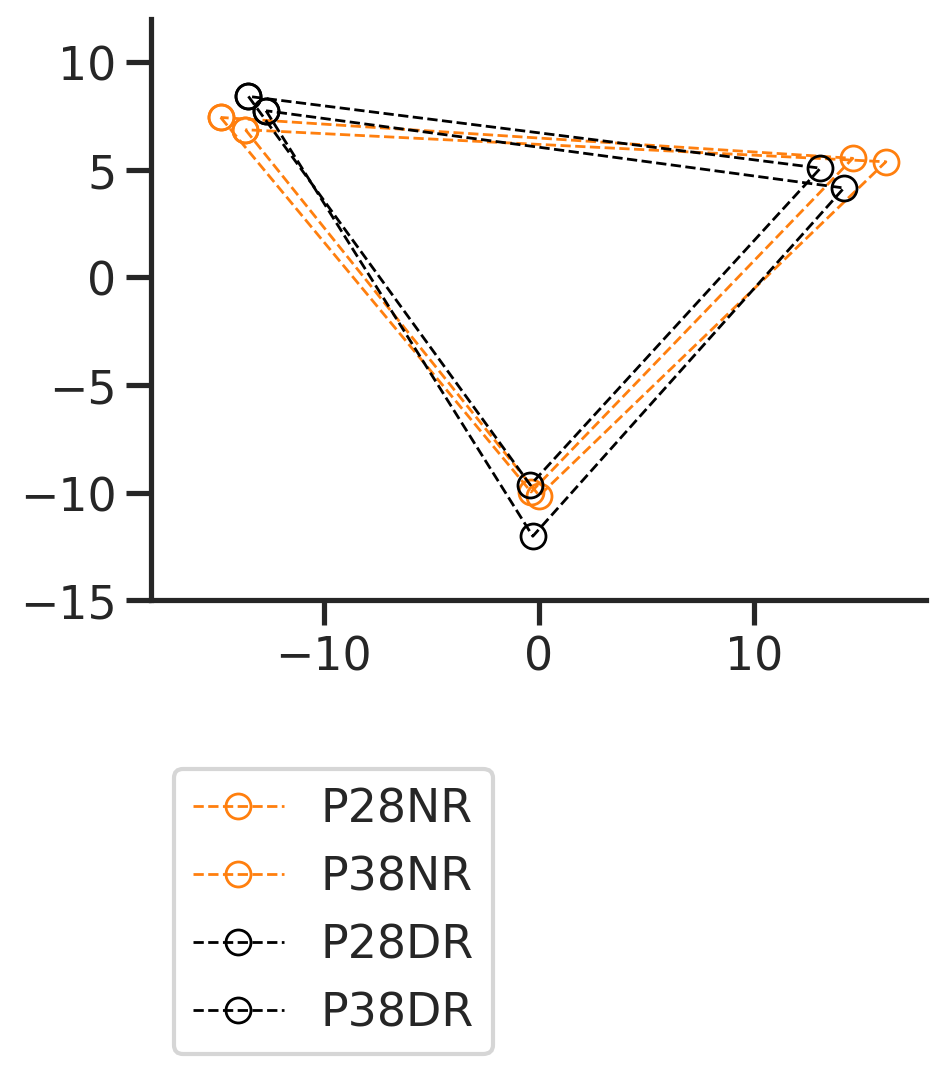

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5*1,1*4)) # , sharex=True, sharey=True)
for lbl in labels:
    XC = XC_dict[lbl]
    color = color_dict[lbl]
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--o', fillstyle='none', label=lbl, color=color, linewidth=1)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

output = os.path.join(outfigdir, 'aa0.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa_1_2024-09-11.pdf


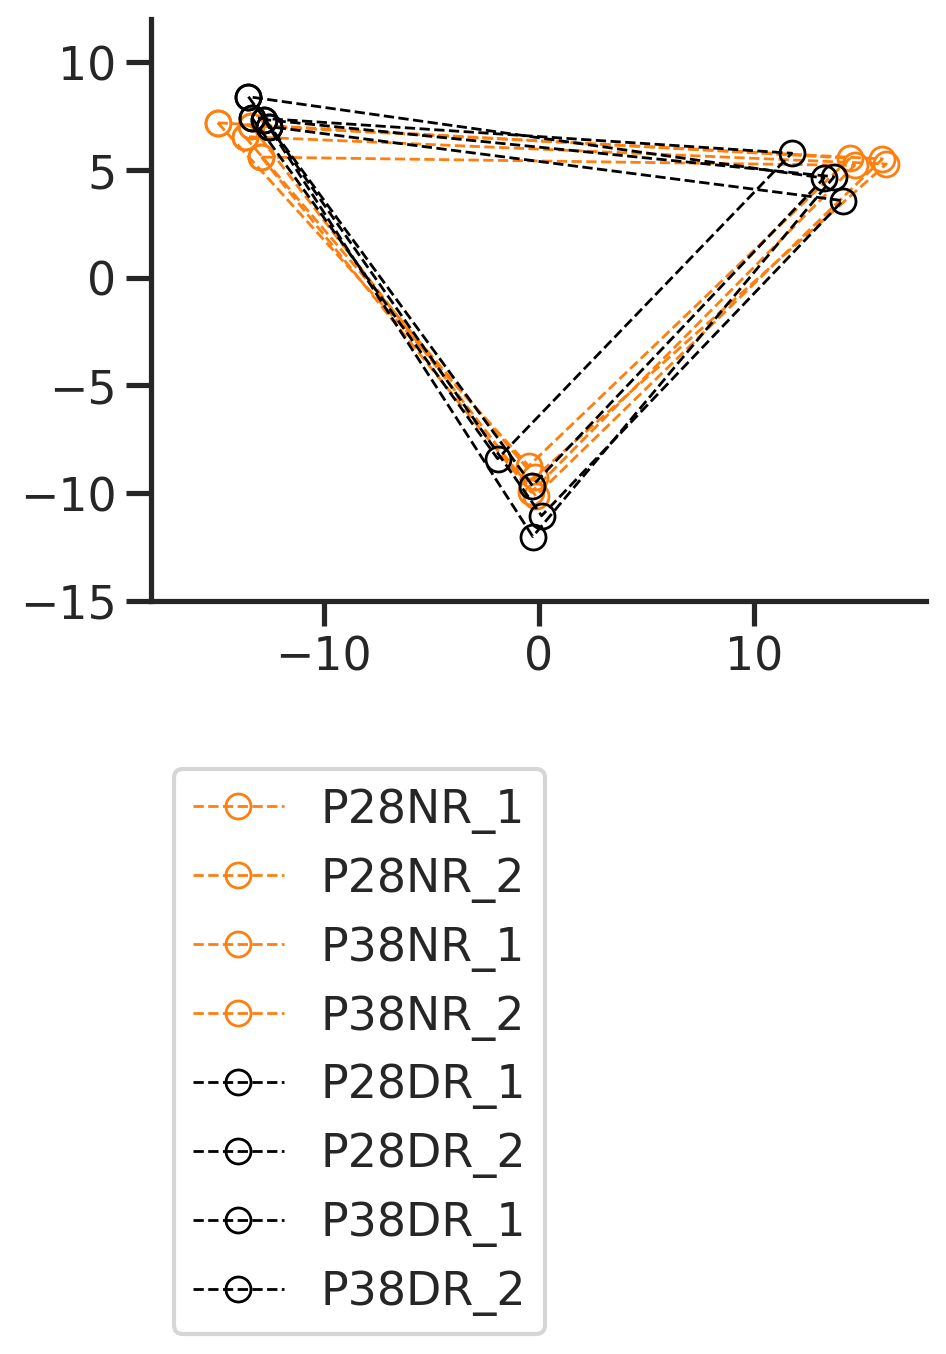

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5*1,1*4)) # , sharex=True, sharey=True)
for lbl in labels_p:
    XC = XC_dict[lbl]
    if 'NR' in lbl:
        color = 'C1'
    elif 'DR' in lbl:
        color = 'k'
    
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--o', fillstyle='none', label=lbl, color=color, linewidth=1)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

output = os.path.join(outfigdir, 'aa_1.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa_2_2024-09-11.pdf


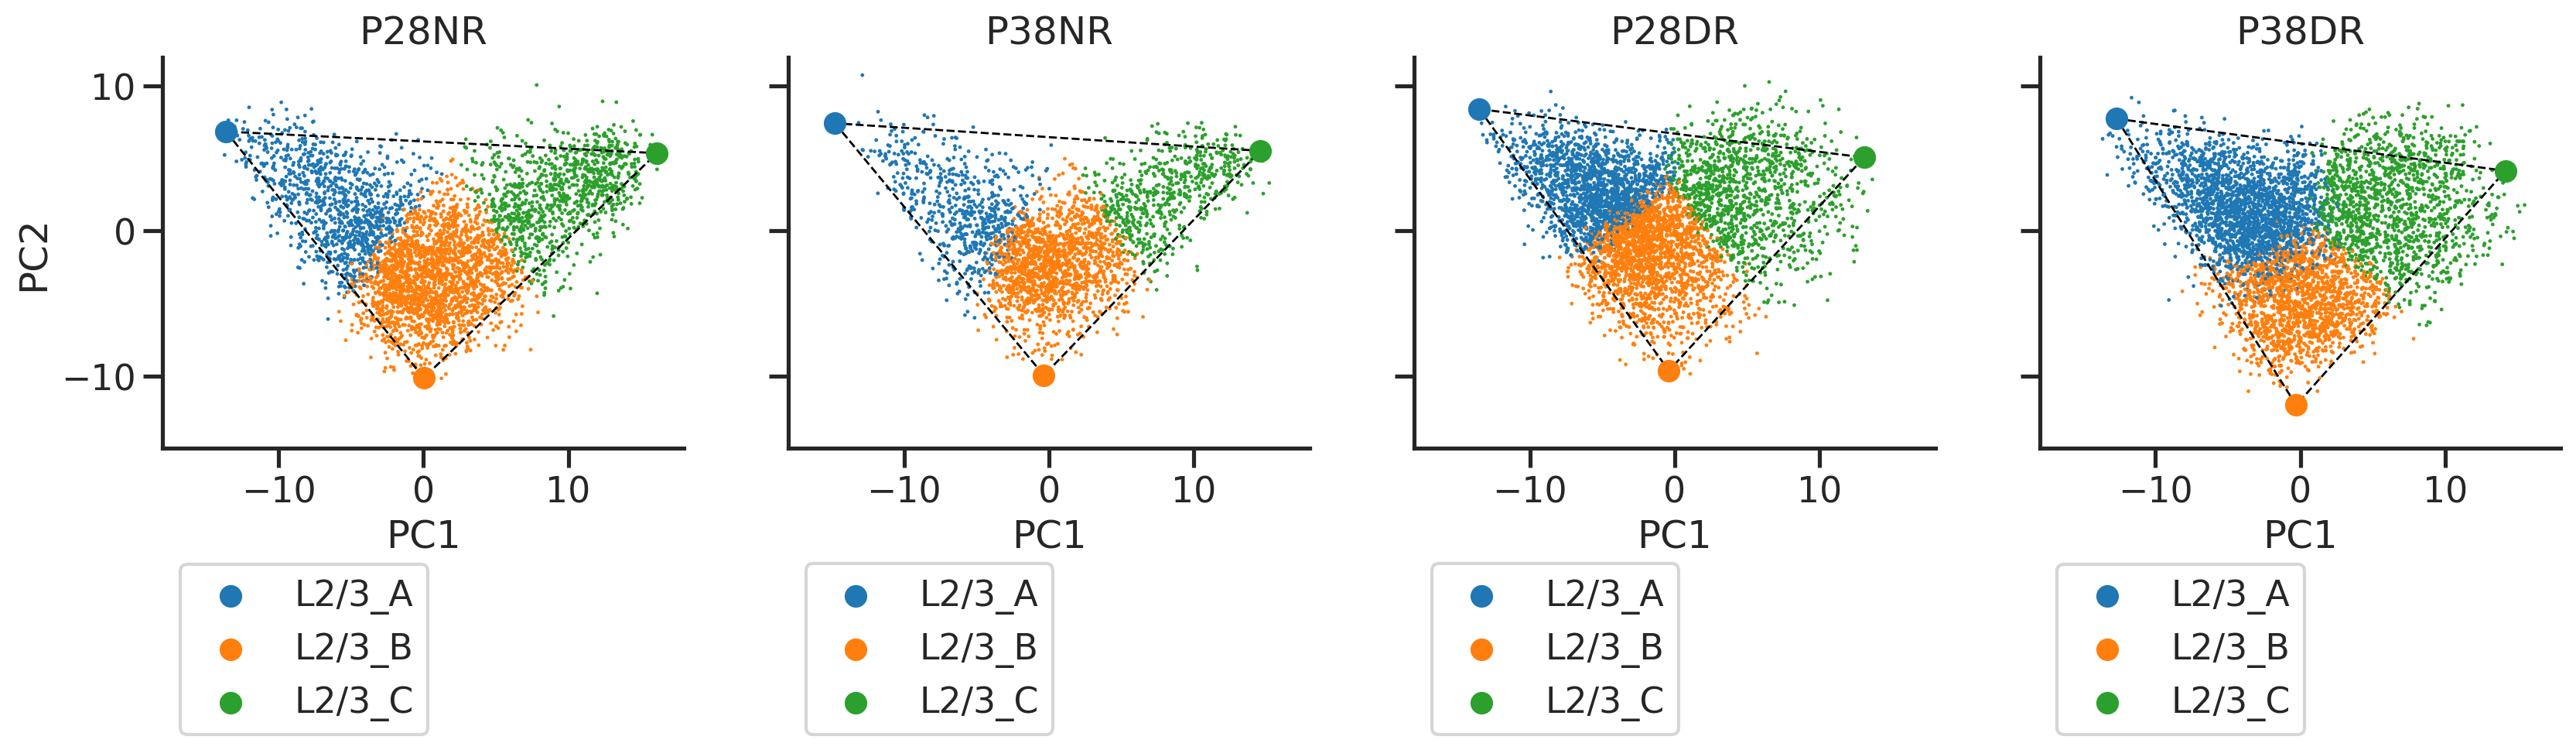

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(5*4,1*4), sharex=True, sharey=True)
for ax, lbl in zip(axs, labels):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    sns.scatterplot(data=adatasub.obs, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), 
                    rasterized=True,
                    ax=ax)
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.legend(bbox_to_anchor=(0,-0.25), loc='upper left')
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.grid(False)
    sns.despine(ax=ax)
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])

output = os.path.join(outfigdir, 'aa_2.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa3_2024-09-11.pdf


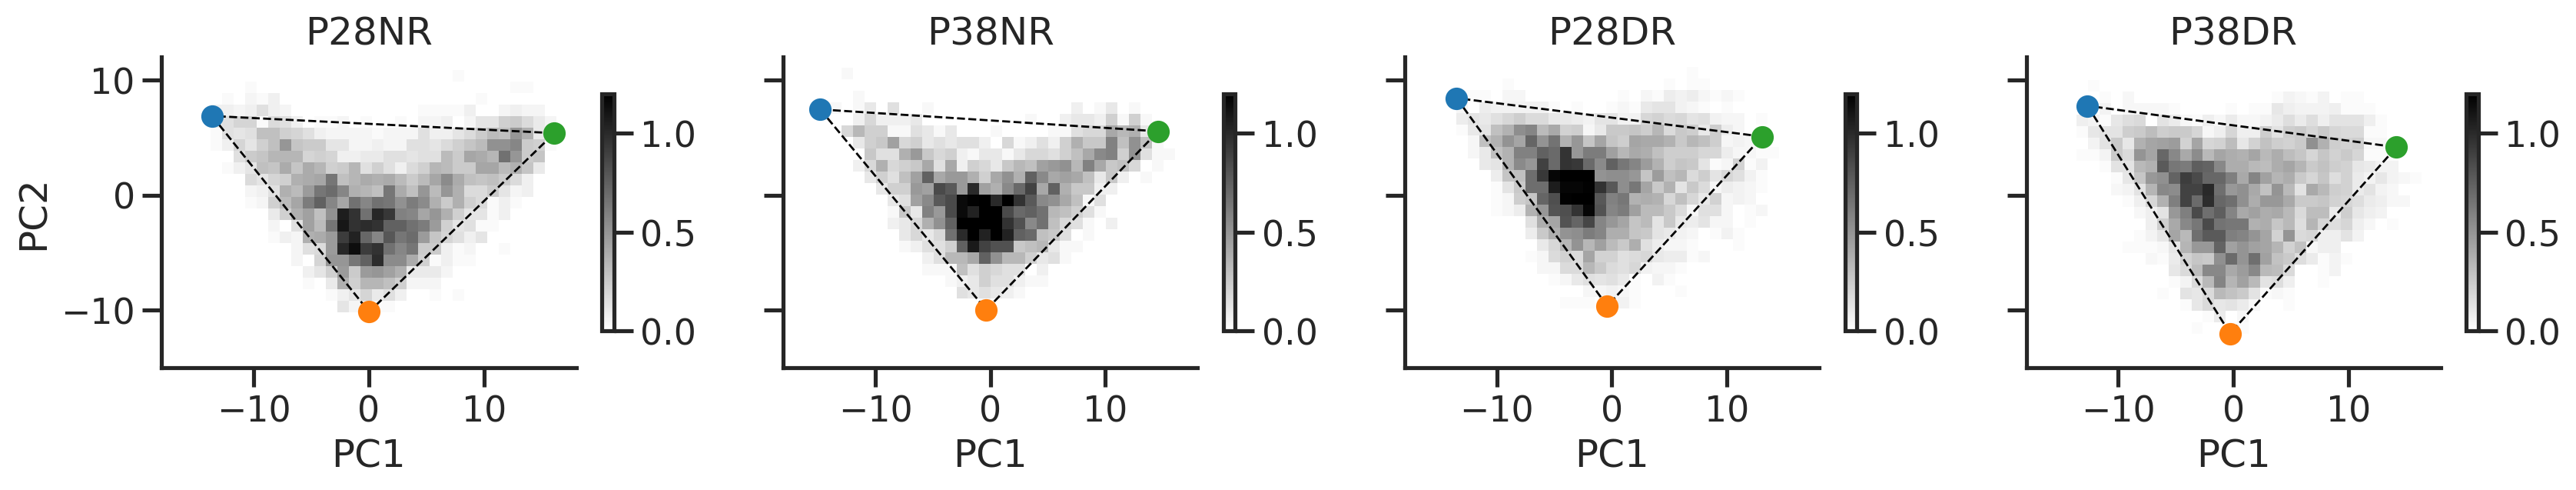

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(5*4,1*4), sharex=True, sharey=True)
for ax, lbl in zip(axs, labels):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl)
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
output = os.path.join(outfigdir, 'aa3.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa_4_2024-09-11.pdf


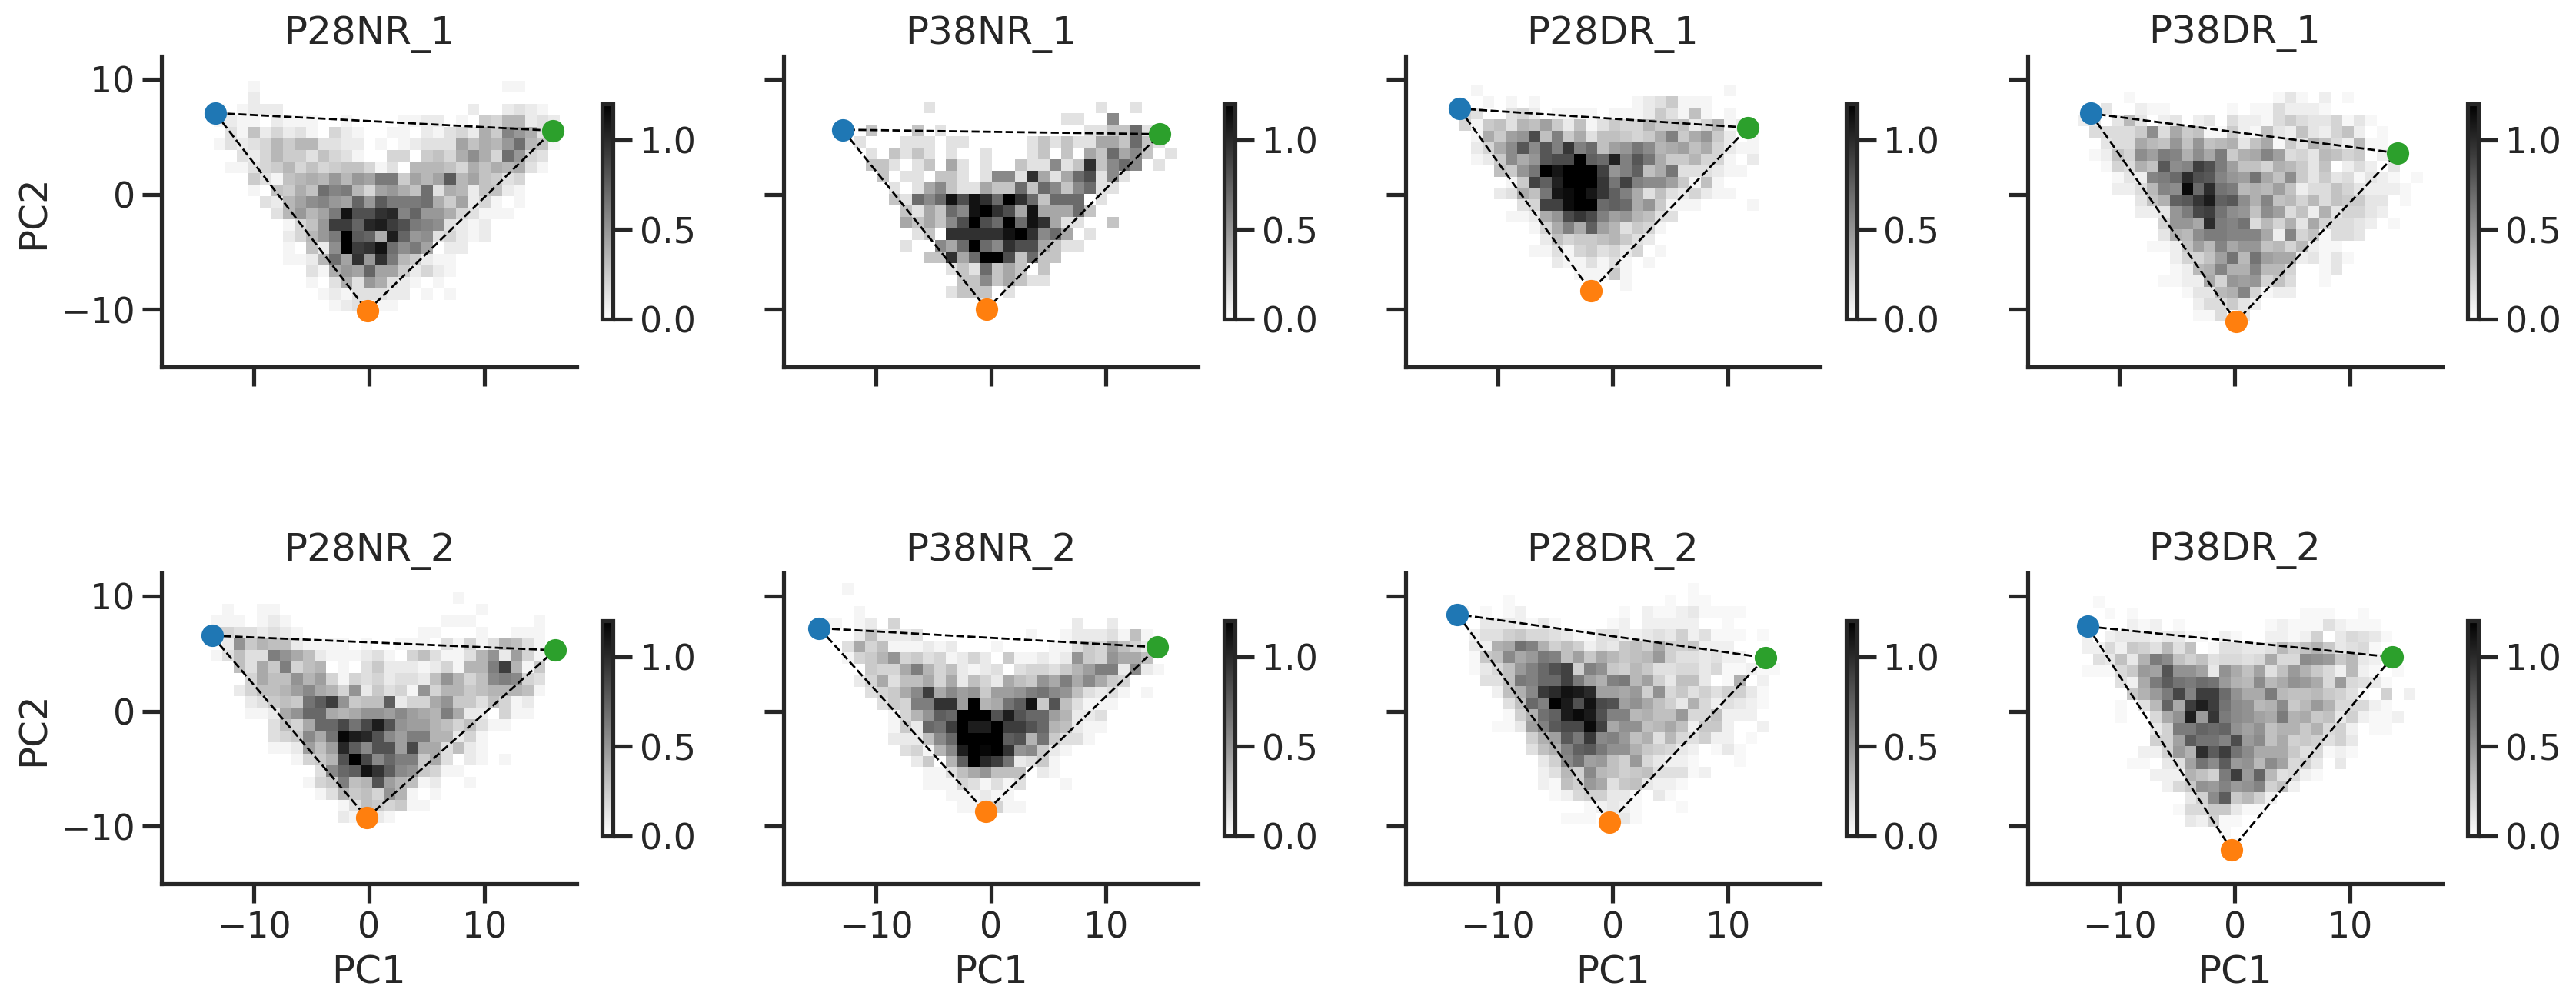

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(5*4,2*4), sharex=True, sharey=True)
for ax, lbl in zip(axs.flat, labels_p2):
    XC = XC_dict[lbl]
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1, vmin=0, vmax=1.2,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
output = os.path.join(outfigdir, 'aa_4.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# fix a common one

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa5_2024-09-11.pdf


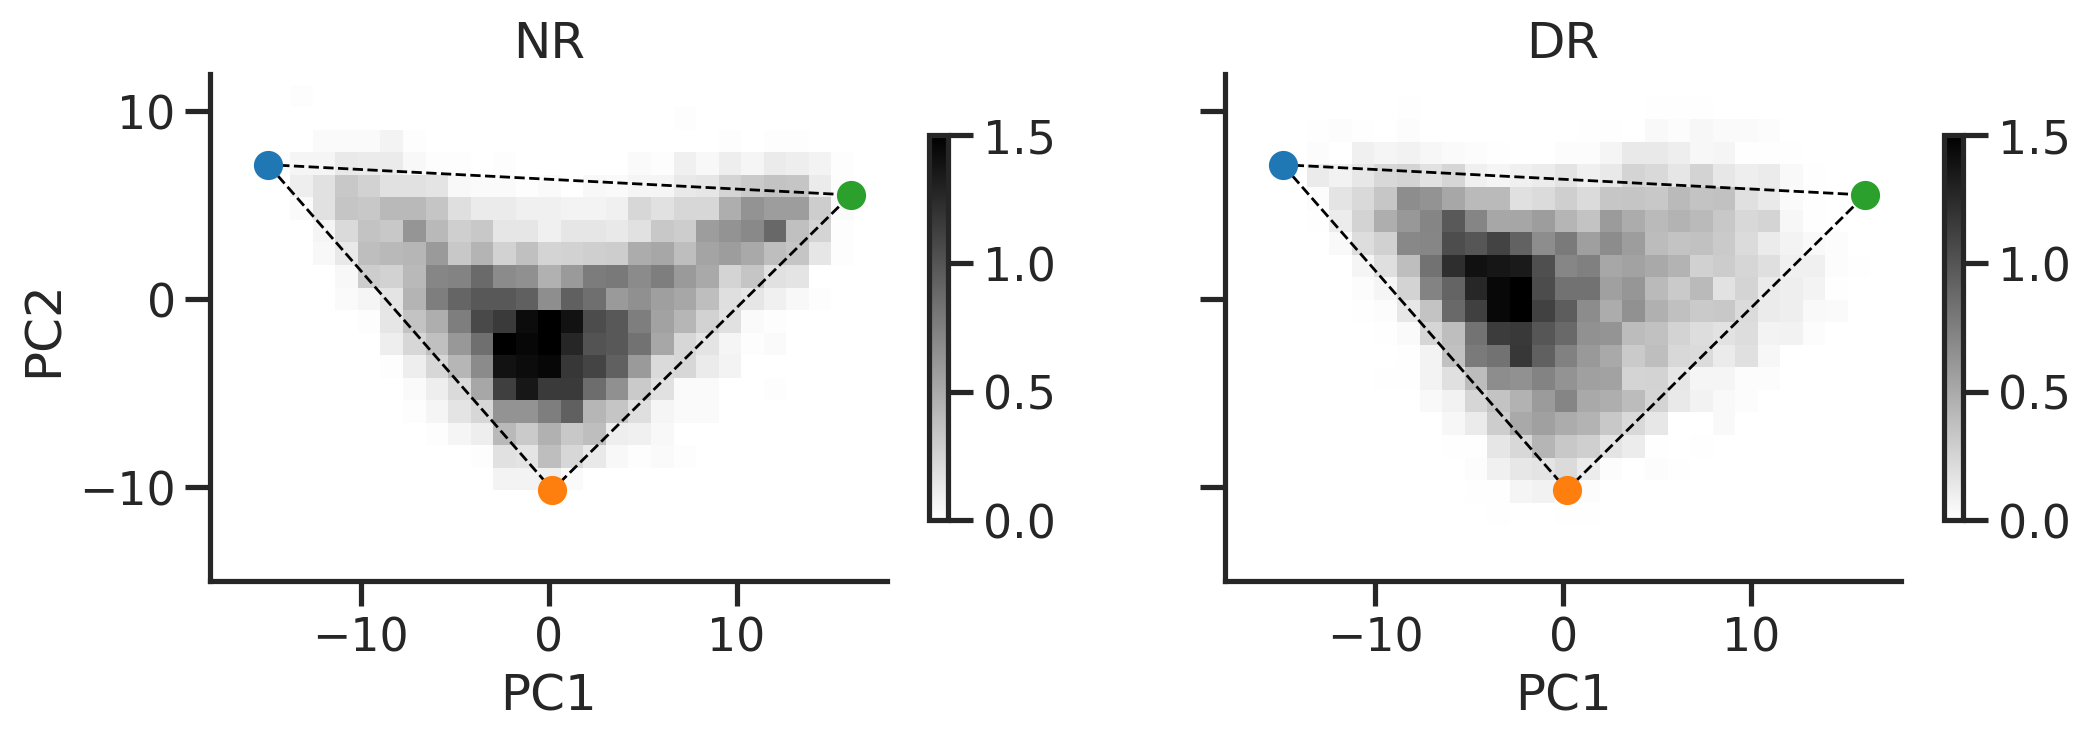

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(6*2,5*1), sharex=True, sharey=True)
XC = XC_dict['NR']
for ax, lbl in zip(axs.flat, labels_m):
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.2, vmin=0, vmax=1.5,
                 cmap='gray_r', cbar=True, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
output = os.path.join(outfigdir, 'aa5.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# quantification

In [34]:
XC_dict.keys()

dict_keys(['P28NR', 'P38NR', 'P28DR', 'P38DR', 'P28NR_1', 'P28NR_2', 'P38NR_1', 'P38NR_2', 'P28DR_1', 'P28DR_2', 'P38DR_1', 'P38DR_2', 'NR', 'DR'])

In [35]:
for lbl in labels_p: 
    diff = XC_dict[lbl]-XC_dict['NR']
    print(diff.shape)
    break

(2, 3)


In [36]:
a = np.stack([XC_dict[lbl].reshape(-1,) for lbl in labels_p[:4]], axis=0)
b = np.stack([XC_dict[lbl].reshape(-1,) for lbl in labels_p[4:]], axis=0)
nr_mean = np.mean(a, axis=0).reshape(2,3)
dr_mean = np.mean(b, axis=0).reshape(2,3)
ref = np.mean(np.vstack([a,b]), axis=0) 

a = a-ref
b = b-ref

In [37]:
dist02 = np.sqrt(np.sum((nr_mean[:,0]-nr_mean[:,2])**2))
dist01 = np.sqrt(np.sum((nr_mean[:,0]-nr_mean[:,1])**2))
dist12 = np.sqrt(np.sum((nr_mean[:,1]-nr_mean[:,2])**2))
dist_min_abc = min(dist01,dist02,dist12)
dist_min_abc

20.979265792892758

In [38]:
dist_shift_nrdr = np.sqrt(np.sum((dr_mean - nr_mean)**2, axis=0))
dist_shift_nrdr/dist_min_abc

array([0.05562828, 0.03888522, 0.1058044 ])

In [39]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
t, ps = stats.ttest_ind(a, b)
rej, qs, _, _ = multipletests(ps, method='fdr_bh')
rej, qs, ps

(array([False, False, False, False, False, False]),
 array([0.32486767, 0.53566821, 0.12574884, 0.2659985 , 0.49102555,
        0.32486767]),
 array([0.21657845, 0.53566821, 0.02095814, 0.08866617, 0.40918796,
        0.16565349]))

Text(0.5, 1.0, 'C')

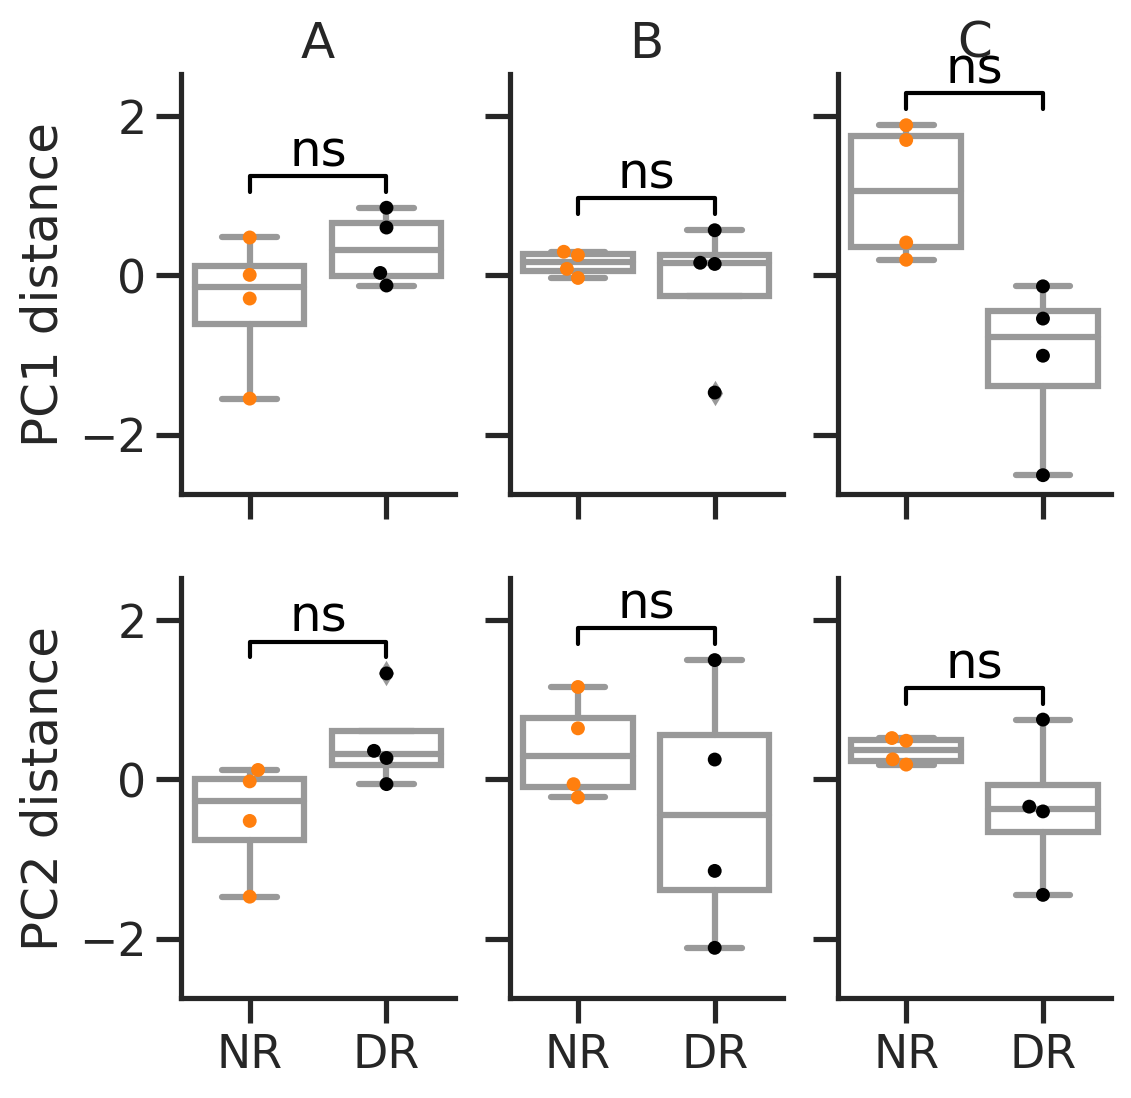

In [40]:
fig, axs = plt.subplots(2,3,figsize=(3*2,2*3), sharex=True, sharey=True)
for i in range(6):
    ax = axs.flat[i]
    sns.boxplot([a[:,i], b[:,i]], color='white', ax=ax)
    sns.swarmplot([a[:,i], b[:,i]], palette=['C1', 'k'], ax=ax)
    ax.set_xticklabels(['NR', 'DR'])
    
        
    q = qs[i]
    # q = ps[i]
    if q > 0.05:
        mark = 'ns'
    elif q < 0.05 and q > 0.001:
        mark = '*'
    elif q < 0.001:
        mark = '***'
    
    # statistical annotation
    x1, x2 = 0, 1   
    y, h = np.hstack([a[:,i], b[:,i]]).max() + 0.2, 0.2 #1, 1
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color='k')
    
    sns.despine(ax=ax)
    ax.grid(False)

axs[0,0].set_ylabel('PC1 distance')
axs[1,0].set_ylabel('PC2 distance')
axs[0,0].set_title('A')
axs[0,1].set_title('B')
axs[0,2].set_title('C')

# label transfer
- all to P28NR using PC1/PC2 space

In [41]:
from sklearn.neighbors import NearestNeighbors

In [42]:
palette_type = {
    'L2/3_A': 'C0',
    'L2/3_B': 'C1',
    'L2/3_C': 'C2',
    'NA': 'gray',
}

In [43]:
ref = adata_nr28.obs.copy()
qry = adata[~adata.obs['sample'].isin(['P28_1a', 'P28_1b', 'P28_2a', 'P28_2b'])].obs.copy()

ref_emb = ref[['PC1', 'PC2']].values
qry_emb = qry[['PC1', 'PC2']].values
ref_lbl = ref['Type'].values.astype(str)
print(np.unique(ref_lbl))

ref_n = len(ref_emb)
qry_n = len(qry_emb)
np.unique(ref_lbl)


k = 30
max_pred, _, dists = neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None)
ps = neighbor_self_nonself(k, ref_emb, qry_emb)

ref['type'] = ref['Type'].astype(str)
qry['type_knn'] = max_pred
qry['type_knn2'] = np.where(ps < 0.95, max_pred, 'NA')

['L2/3_A' 'L2/3_B' 'L2/3_C']


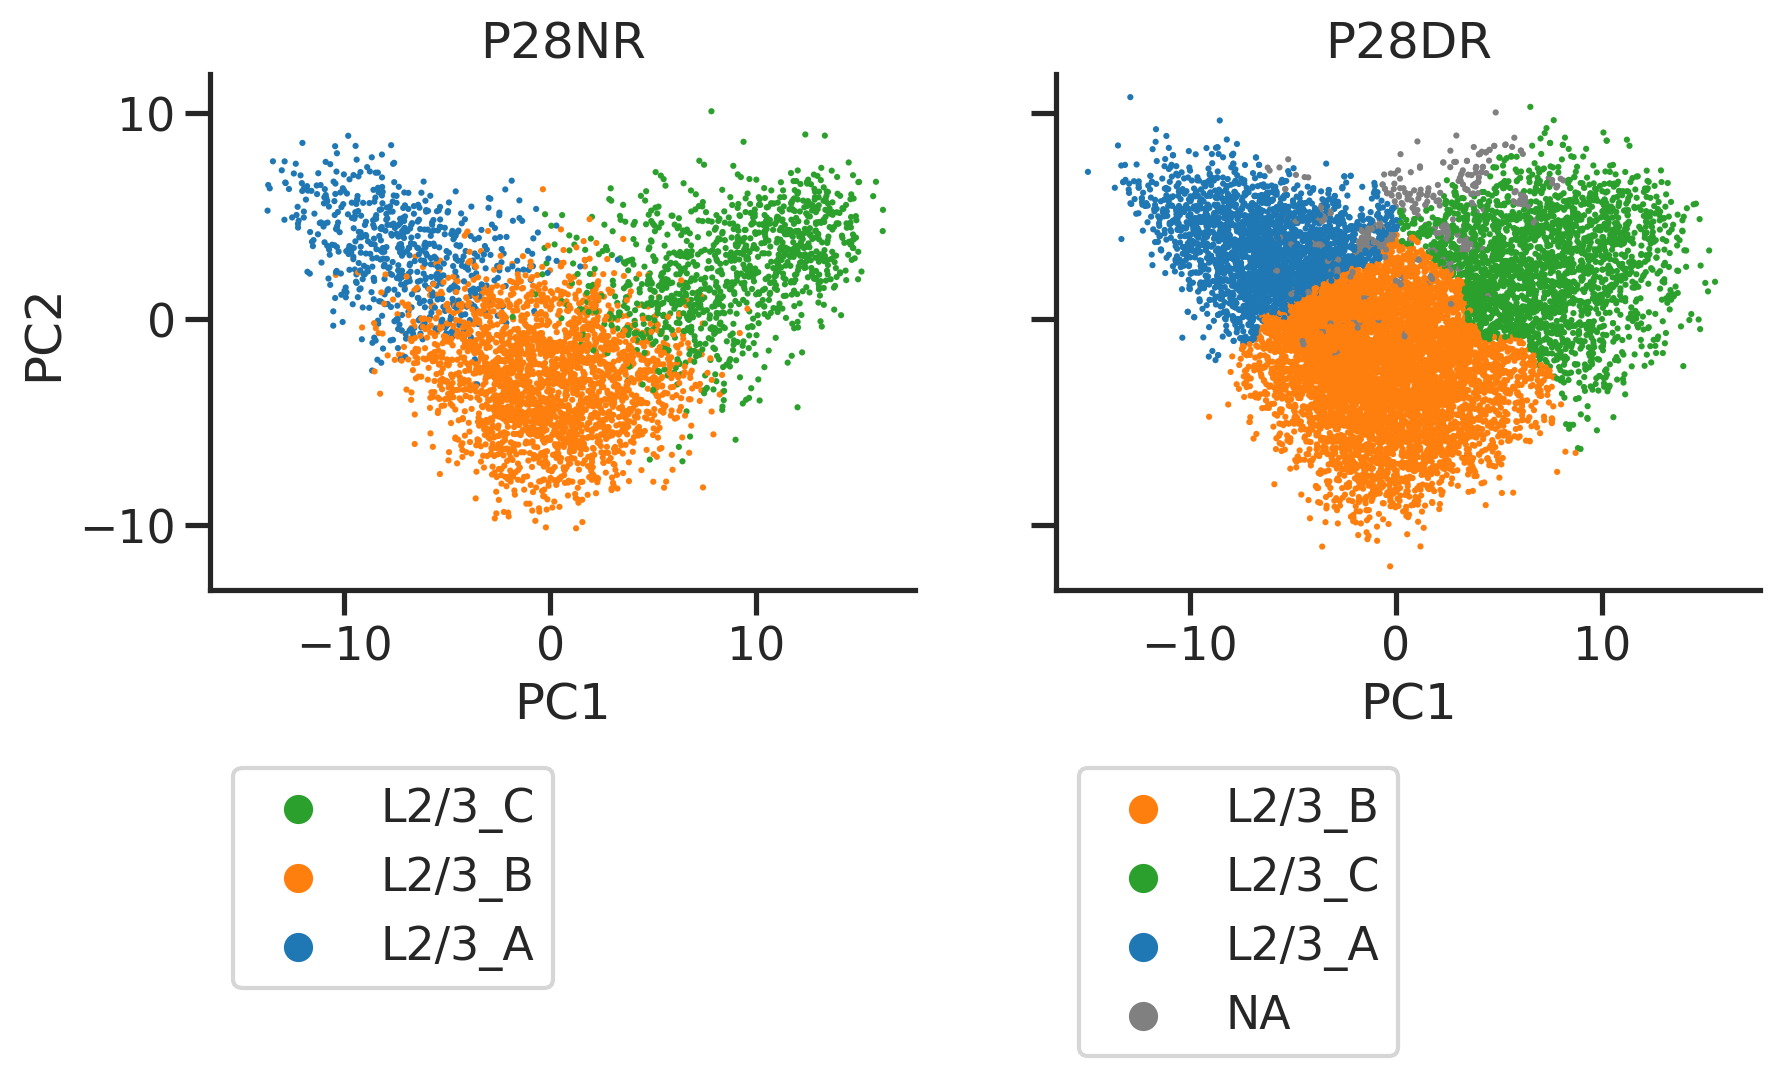

In [44]:
fig, axs = plt.subplots(1,2,figsize=(2*5, 1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=ref, x='PC1', y='PC2', hue='type', s=5, 
                edgecolor='none', palette=palette_type, ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left')
sns.despine(ax=ax)
ax.set_aspect('equal')
ax.grid(False)
ax.set_title('P28NR')

ax = axs[1]
sns.scatterplot(data=qry, x='PC1', y='PC2', hue='type_knn2', s=5, 
                edgecolor='none', palette=palette_type, ax=ax, rasterized=True)
ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left')
sns.despine(ax=ax)
ax.set_aspect('equal')
ax.grid(False)
ax.set_title('P28DR')


# output = os.path.join(outfigdir, "figS1_nr_pc34.pdf")
# powerplots.savefig(fig, output)
plt.show()

In [54]:
counts1 = ref.groupby(['biosample', 'type']).size().unstack()
counts2 = qry.groupby(['biosample', 'type_knn']).size().unstack()
counts = pd.concat([counts1, counts2]).fillna(0)
res = counts.divide(counts.sum(axis=1), axis=0)*100
res['cond'] = np.where(res.index.str.contains('dr'), 'DR', 'NR') #[samp.split('_')[1] for samp in freqs.index.values]
res

L2/3_A     L2/3_B     L2/3_C cond
biosample                                      
P28_1      14.292612  58.812168  26.895220   NR
P28_2      16.016219  58.996452  24.987329   NR
P28_dr_1   32.769766  47.787171  19.443063   DR
P28_dr_3   29.669514  51.986632  18.343854   DR
P38_1       6.527778  67.083333  26.388889   NR
P38_2      16.135559  61.911988  21.952453   NR
P38_dr_1   22.382523  56.883759  20.733718   DR
P38_dr_2   19.240599  57.539248  23.220153   DR

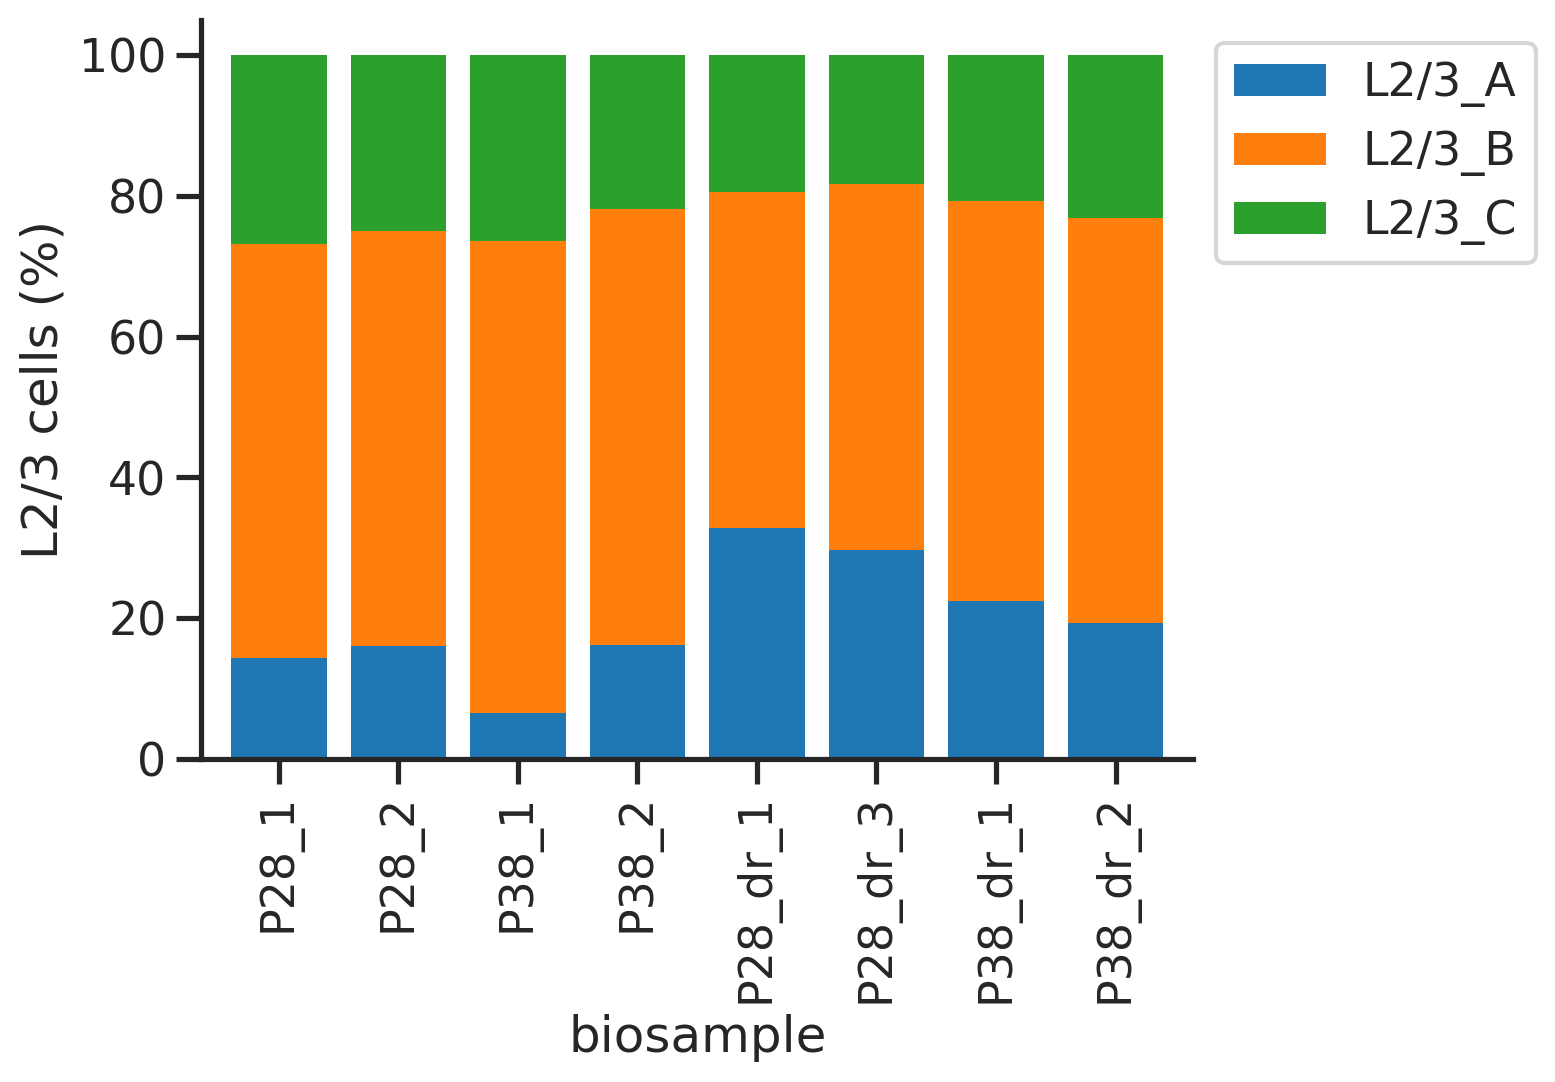

In [55]:
samples = ['P28_1','P28_2', 'P38_1', 'P38_2', 
           'P28_dr_1', 'P28_dr_3', 'P38_dr_1', 'P38_dr_2']
fig, ax = plt.subplots()
res.loc[samples].plot.bar(ax=ax, stacked=True, width=0.8, color=['C0', 'C1', 'C2', 'gray'], edgecolor='none')
ax.grid(False)
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('L2/3 cells (%)')
plt.show()

In [56]:
def p_mark(p):
    """
    """
    
    if p > 0.05:
        mark = 'ns'
    elif p < 0.05 and p > 0.001:
        mark = '*'
    elif p < 0.001:
        mark = '***'
        
    return mark

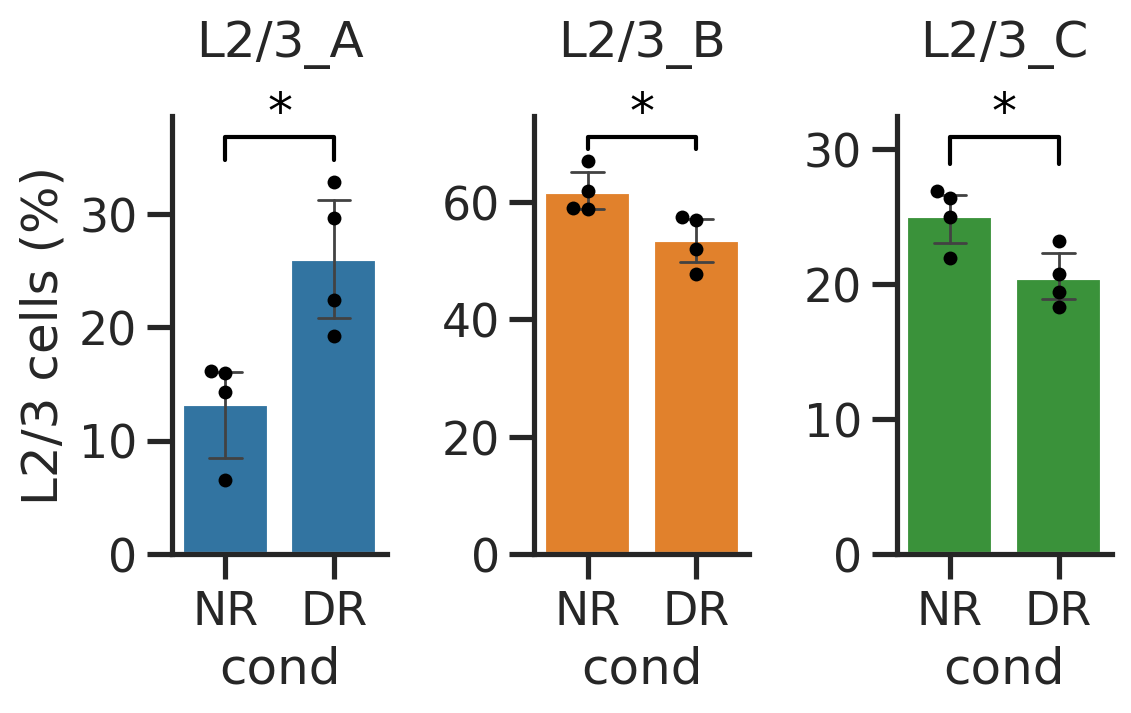

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(2*3,4)) #sharex=True, sharey=True)
# unq_lbls, unq_colors = ['L2/3_A', 'L2/3_B', 'L2/3_C', 'NA'], ['C0', 'C1', 'C2', 'gray']
unq_lbls, unq_colors = ['L2/3_A', 'L2/3_B', 'L2/3_C', ], ['C0', 'C1', 'C2', ]
allps = []
for ax, col, color in zip(axs, unq_lbls, unq_colors):
    sns.barplot(data=res, x='cond', y=col, ax=ax, color=color, capsize=0.3, errwidth=1)
    sns.swarmplot(data=res, x='cond', y=col, color='k', ax=ax, )
    ax.set_title(f'{col}', y=1.1)
    sns.despine(ax=ax)
    ax.grid(False)
    ax.set_ylabel('')
    
    a = res[res['cond']=='NR'][col]#/100
    b = res[res['cond']=='DR'][col]#/100
    t, p = stats.ttest_ind(a, b)
    # s, p = stats.mannwhitneyu(a, b)
    
    allps.append(p)
    
rej, allqs, _, _ = multipletests(allps, method='fdr_bh')
for ax, col, color, q in zip(axs, unq_lbls, unq_colors, allqs):
    mark = p_mark(q)
    # statistical annotation
    x1, x2 = 0, 1   
    y, h = res[col].max() + 2, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color='k')
    
    
axs[0].set_ylabel('L2/3 cells (%)')
fig.tight_layout()
plt.show()



# score based (ABC) soft-assignment

In [59]:
# get ABC scores
g0_a = stats.zscore(np.array(adata[:,agenes].layers['lognorm'].todense()), axis=0).mean(axis=1)
g0_b = stats.zscore(np.array(adata[:,bgenes].layers['lognorm'].todense()), axis=0).mean(axis=1)
g0_c = stats.zscore(np.array(adata[:,cgenes].layers['lognorm'].todense()), axis=0).mean(axis=1)

# g0_b = adata[:,bgenes].layers['lognorm'].mean(axis=1)
# g0_c = adata[:,cgenes].layers['lognorm'].mean(axis=1)
# g0_a = np.array(g0_a).reshape(-1,)
# g0_b = np.array(g0_b).reshape(-1,)
# g0_c = np.array(g0_c).reshape(-1,)

# make ABC scores comparable and norm to [0,1] [40% to 95%]
vmin_p, vmax_p = 40, 95
vmin_a = np.percentile(g0_a, vmin_p)
vmax_a = np.percentile(g0_a, vmax_p)

vmin_b = np.percentile(g0_b, vmin_p)
vmax_b = np.percentile(g0_b, vmax_p)

vmin_c = np.percentile(g0_c, vmin_p)
vmax_c = np.percentile(g0_c, vmax_p)

g0_a = np.clip((g0_a-vmin_a)/(vmax_a-vmin_a), 0, 1)
g0_b = np.clip((g0_b-vmin_b)/(vmax_b-vmin_b), 0, 1)
g0_c = np.clip((g0_c-vmin_c)/(vmax_c-vmin_c), 0, 1)

# separate them into scale and frequency
g0_sum  = (g0_a+g0_b+g0_c)
freq0_a = g0_a/(g0_sum+1e-5)
freq0_b = g0_b/(g0_sum+1e-5)
freq0_c = g0_c/(g0_sum+1e-5)

adata.obsm['size_freq_abc'] = np.vstack([freq0_a, freq0_b, freq0_c, g0_sum]).T

In [60]:
res = []
for sample in samples: 
    if 'dr' in sample:
        cond = 'DR'
    else:
        cond = 'NR'
        
    adatasub = adata[adata.obs['biosample']==sample]
    freq_a = adatasub.obsm['size_freq_abc'][:,0]
    freq_b = adatasub.obsm['size_freq_abc'][:,1]
    freq_c = adatasub.obsm['size_freq_abc'][:,2]
    
    n = len(adatasub)
    
    cond_na = (freq_a+freq_b+freq_c)<1e-1
    tn = np.sum(cond_na)
    
    rank = np.argsort(np.vstack([freq_a,freq_b,freq_c]).T[~cond_na], axis=1)[:,-1]
    ta = np.sum(rank==0)
    tb = np.sum(rank==1)
    tc = np.sum(rank==2)
    
    assert np.abs(n-(ta+tb+tc)-tn) < 1e-1
    res.append([sample, cond, ta/n*100, tb/n*100, tc/n*100, tn/n*100])
    
res = pd.DataFrame(res, columns=['sample', 'cond', 'A', 'B', 'C', 'N']).set_index('sample')
res

cond          A          B          C         N
sample                                                  
P28_1      NR  21.294061  42.974408  35.634959  0.096572
P28_2      NR  27.318804  40.800811  31.626964  0.253421
P38_1      NR  16.944444  43.611111  38.750000  0.694444
P38_2      NR  28.882145  38.290339  32.574608  0.252908
P28_dr_1   DR  51.964197  20.338140  27.498757  0.198906
P28_dr_3   DR  46.082436  27.218715  26.327516  0.371333
P38_dr_1   DR  35.408079  33.965375  30.173124  0.453421
P38_dr_2   DR  31.580869  35.560424  32.712669  0.146039

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/1_2024-09-11.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/1.pdf


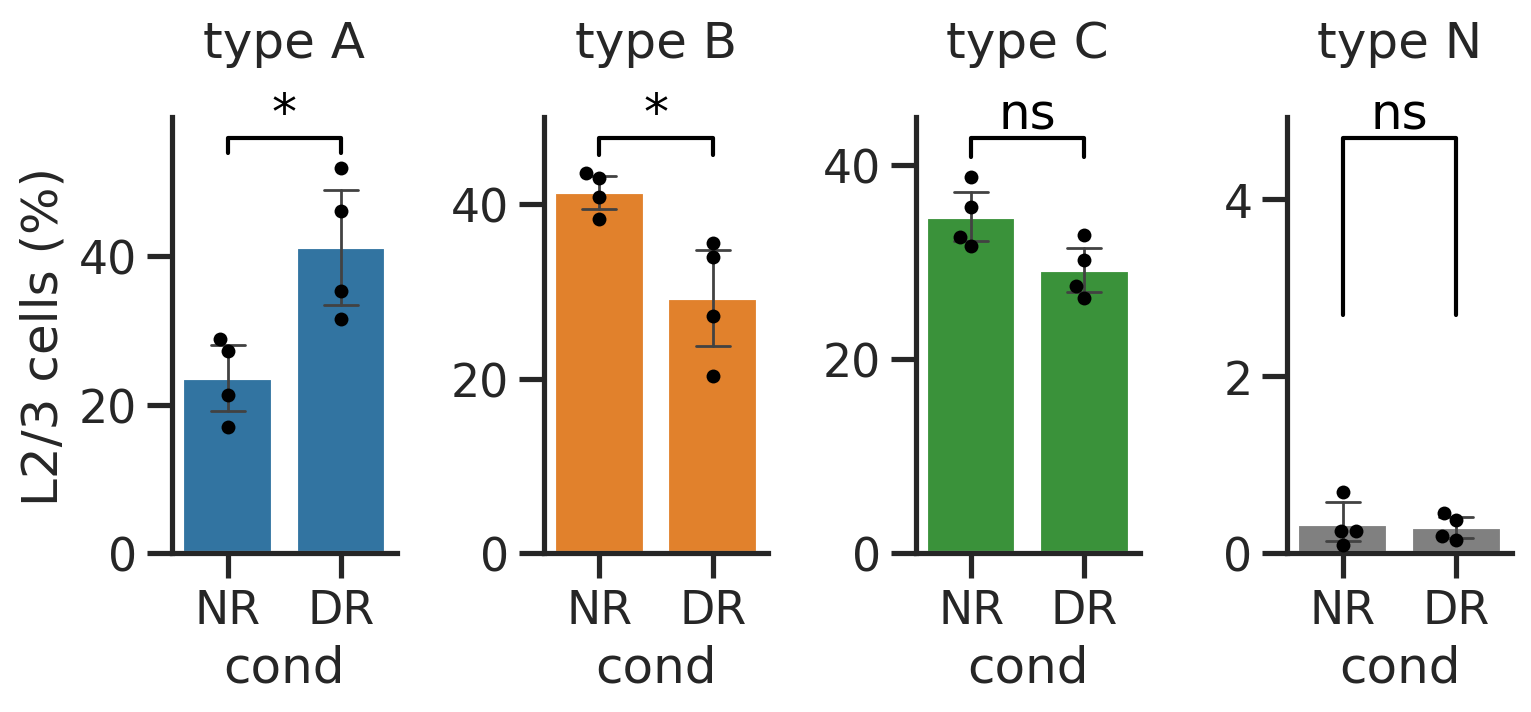

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(2*4,4))
unq_lbls = ['A', 'B', 'C', 'N']
unq_colors = ['C0', 'C1', 'C2', 'gray']

allps = []
for ax, col, color in zip(axs, unq_lbls, unq_colors):
    sns.barplot(data=res, x='cond', y=col, ax=ax, color=color, capsize=0.3, errwidth=1)
    sns.swarmplot(data=res, x='cond', y=col, color='k', ax=ax, )
    ax.set_title(f'type {col}', y=1.1)
    sns.despine(ax=ax)
    ax.grid(False)
    ax.set_ylabel('')
    
    a = res[res['cond']=='NR'][col]
    b = res[res['cond']=='DR'][col]
    # s, p = stats.mannwhitneyu(a, b)
    s, p = stats.ttest_ind(a, b)
    
    allps.append(p)
    
rej, allqs, _, _ = multipletests(allps, method='fdr_bh')
for ax, col, color, q in zip(axs, unq_lbls, unq_colors, allqs):
    mark = p_mark(q)
    # statistical annotation
    x1, x2 = 0, 1   
    y, h = res[col].max() + 2, 2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color='k')
    
axs[0].set_ylabel('L2/3 cells (%)')
fig.tight_layout()
fig_manager.savefig(fig)
plt.show()

In [52]:
from matplotlib.colors import LinearSegmentedColormap

colors_a = [(0.0, 'black'), (1.0, 'C0')]      
colors_b = [(0.0, 'black'), (1.0, 'C1')]      
colors_c = [(0.0, 'black'), (1.0, 'C2')]      

# Create a custom colormap using LinearSegmentedColormap
cmap_a = LinearSegmentedColormap.from_list('cmap_a', colors_a)
cmap_b = LinearSegmentedColormap.from_list('cmap_b', colors_b)
cmap_c = LinearSegmentedColormap.from_list('cmap_c', colors_c)

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/1_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/1.pdf


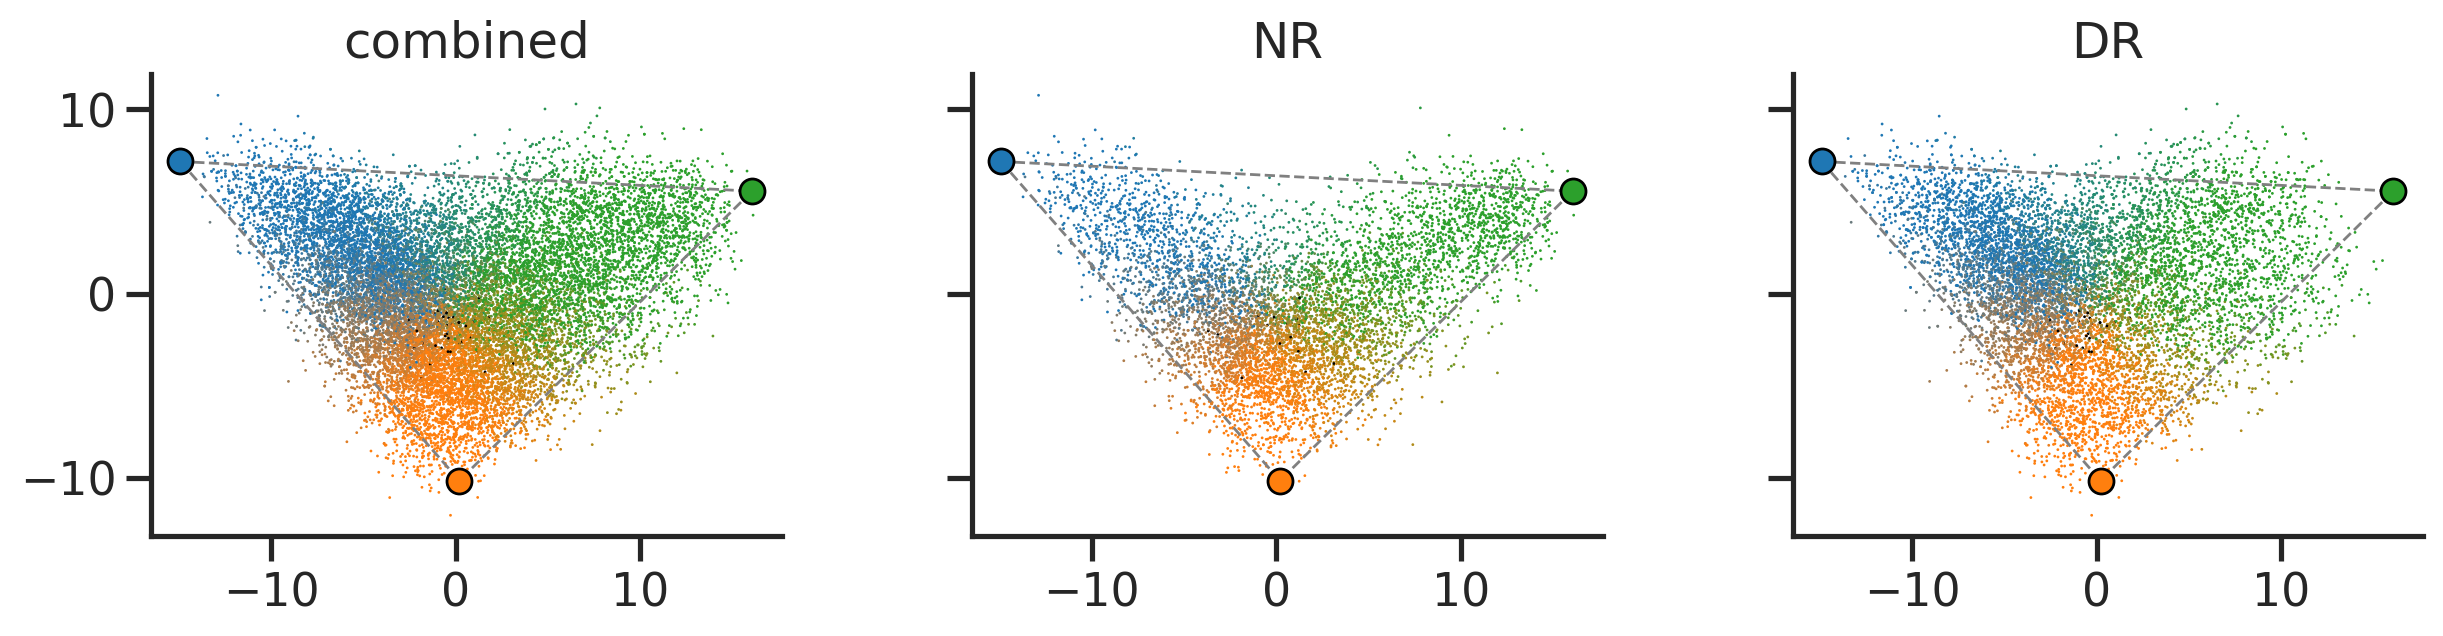

In [53]:
adatas = [
    adata,
    adata[~adata.obs['sample'].str.contains('dr')],
    adata[adata.obs['sample'].str.contains('dr')],
]
conditions = ['combined', 'NR', 'DR']

fig, axs = plt.subplots(1,3,figsize=(3*5,1*3), sharex=True, sharey=True)
for i, (ax, adatasub, condition) in enumerate(zip(axs, adatas, conditions)):
    condition = conditions[i]
    x = adatasub.obs['PC1'].values
    y = adatasub.obs['PC2'].values
    
    freq_a = adatasub.obsm['size_freq_abc'][:,0]
    freq_b = adatasub.obsm['size_freq_abc'][:,1]
    freq_c = adatasub.obsm['size_freq_abc'][:,2]
    
    # visualize ABC scores using additive blending
    additive = (cmap_a(freq_a)+cmap_b(freq_b)+cmap_c(freq_c))[:,:3]
    p = ax.scatter(x, y, c=additive, s=1, edgecolor='none', rasterized=True) 
        
    # Show ticks but no grid
    ax.set_aspect('equal')
    ax.axis('on')
    ax.grid(False)  # Turn off grid lines
    sns.despine(ax=ax)
    ax.tick_params(axis='both', which='both', bottom=True, left=True)
    ax.set_title(condition)

    # add the triangle
    add_triangle(XC, ax, vertices=True, edgecolors='k', linewidths=1, marker='o', zorder=2)
    # break
fig_manager.savefig(fig)
# plt.show()

# save this

In [54]:
# f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes_july8_2024.csv"
# res_qry.to_csv(f, header=True, index=True)

# Optimal Transport

In [55]:
import ot
import ot.plot
from matplotlib import collections as mc

In [56]:
def OT_pipe(xs, xt, numbins=12):
    """
    xs = X_nr28.dot(V)[:,:2]
    xt = X_dr28.dot(V)[:,:2]
    """
    ns = len(xs)
    nt = len(xt)
    a = np.ones((ns,))/ns
    b = np.ones((nt,))/nt
    print(xs.shape, xt.shape)
    
    # ~5 sec for 4k cells vs 4k cells
    M = ot.dist(xs, xt)
    G0 = ot.emd(a, b, M)
    G0n = G0/np.array(G0.sum(axis=1)+1e-10).reshape(-1,1) #.shape
    
    # organize results (ns, nt)
    G0ns = sparse.coo_matrix(G0n)
    
    # per source cell vector
    alli, allj, allw = G0ns.row, G0ns.col, G0ns.data
    tmp = pd.DataFrame((xt[allj] - xs[alli])*allw.reshape(-1,1))
    tmp[2] = alli
    arrows = tmp.groupby(2).sum().reindex(np.arange(ns)).values
    
    # organize per cell vector 
    arrows = pd.DataFrame(arrows, columns=['dx', 'dy'])
    arrows['x'] = xs[:,0]
    arrows['y'] = xs[:,1]
    arrows['xbin'] = pd.cut(xs[:,0], numbins, labels=False)
    arrows['ybin'] = pd.cut(xs[:,1], numbins, labels=False)
    
    # local mean field
    n_arrows = arrows.groupby(['xbin', 'ybin']).size()
    n_arrows = n_arrows[n_arrows!=0]
    mean_arrows = arrows.groupby(['xbin', 'ybin']).mean().reindex(n_arrows.index).fillna(0) #.dropna()
    
    mags = np.sqrt(arrows['dx']**2+arrows['dy']**2)  # n_arrows # [[2,3]] #*n_arrows
    mean_mags = np.mean(mags)
    
    return G0ns, arrows, n_arrows, mean_arrows, mean_mags
    

In [57]:
def OT_plot(n_arrows, mean_arrows, XC, output=None):
    """
    """
    maxsize = np.max(n_arrows)
    minsize = np.min(n_arrows)
    print(minsize, maxsize)

    fig, ax = plt.subplots(figsize=(7,5))
    for size, arrow in zip(n_arrows.values, mean_arrows[['x', 'y', 'dx', 'dy']].values):
        ax.arrow(*arrow, linewidth=1, width=0.2, alpha=size/maxsize, edgecolor='none', facecolor='k')

    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    ax.set_aspect('equal')
    if output:
        powerplots.savefig_autodate(fig, output)
    plt.show()
    
def OT_plot_ax(ax, n_arrows, mean_arrows):
    """
    """
    maxsize = np.max(n_arrows)
    minsize = np.min(n_arrows)
    print(minsize, maxsize)
    for size, arrow in zip(n_arrows.values, mean_arrows[['x', 'y', 'dx', 'dy']].values):
        ax.arrow(*arrow, linewidth=1, width=0.2, alpha=size/maxsize, edgecolor='none', facecolor='k')

In [58]:
ot_res = dict()

XC = XC_dict['NR']
xs = adata_nr.obsm['pcs'][:,:2]
xt = adata_dr.obsm['pcs'][:,:2]
_, _, n_arrows, mean_arrows, mean_mags = OT_pipe(xs, xt, numbins=15)
ot_res['NR vs DR'] = (n_arrows, mean_arrows, mean_mags)

(6741, 2) (9869, 2)


/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


1 210


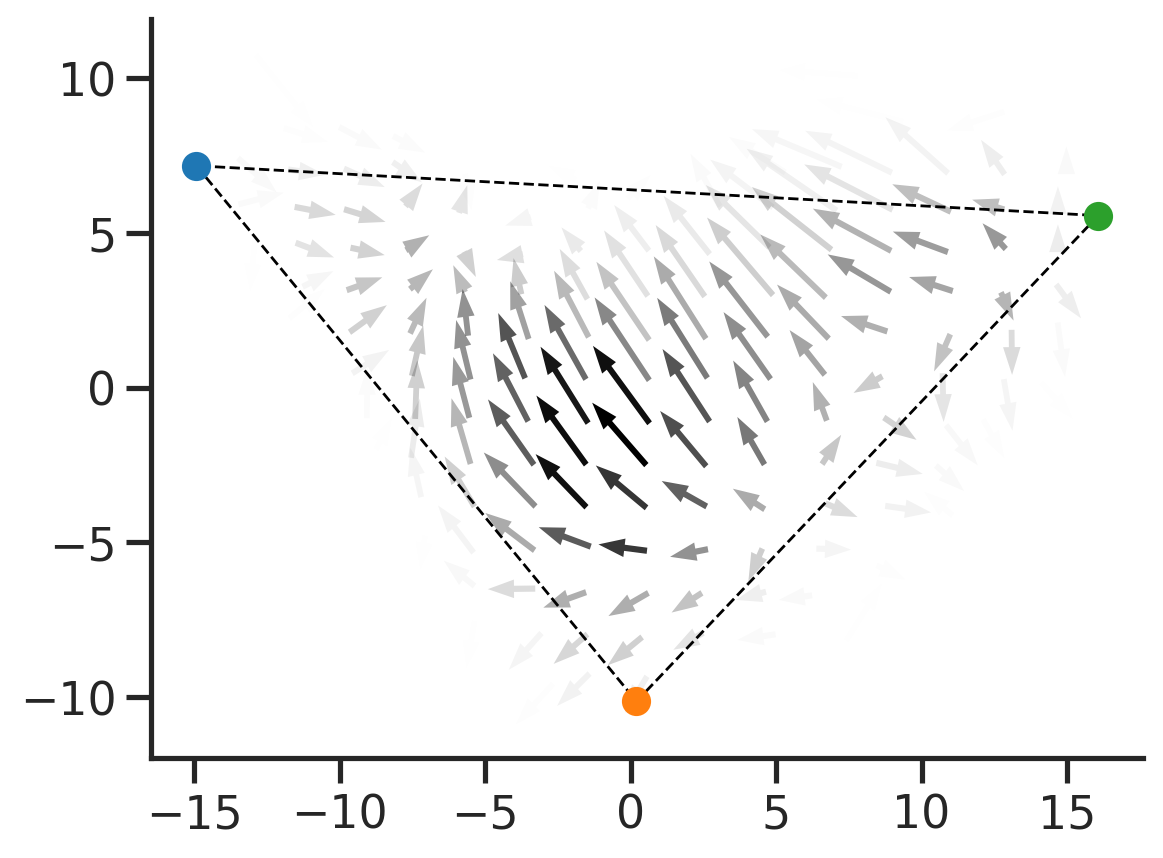

In [59]:
output = os.path.join(outfigdir, 'ot_nrdr.pdf')

fig, ax = plt.subplots()
OT_plot_ax(ax, n_arrows, mean_arrows)
add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
ax.grid(False)
sns.despine(ax=ax)

1 210
saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/aa6_2024-09-10.pdf


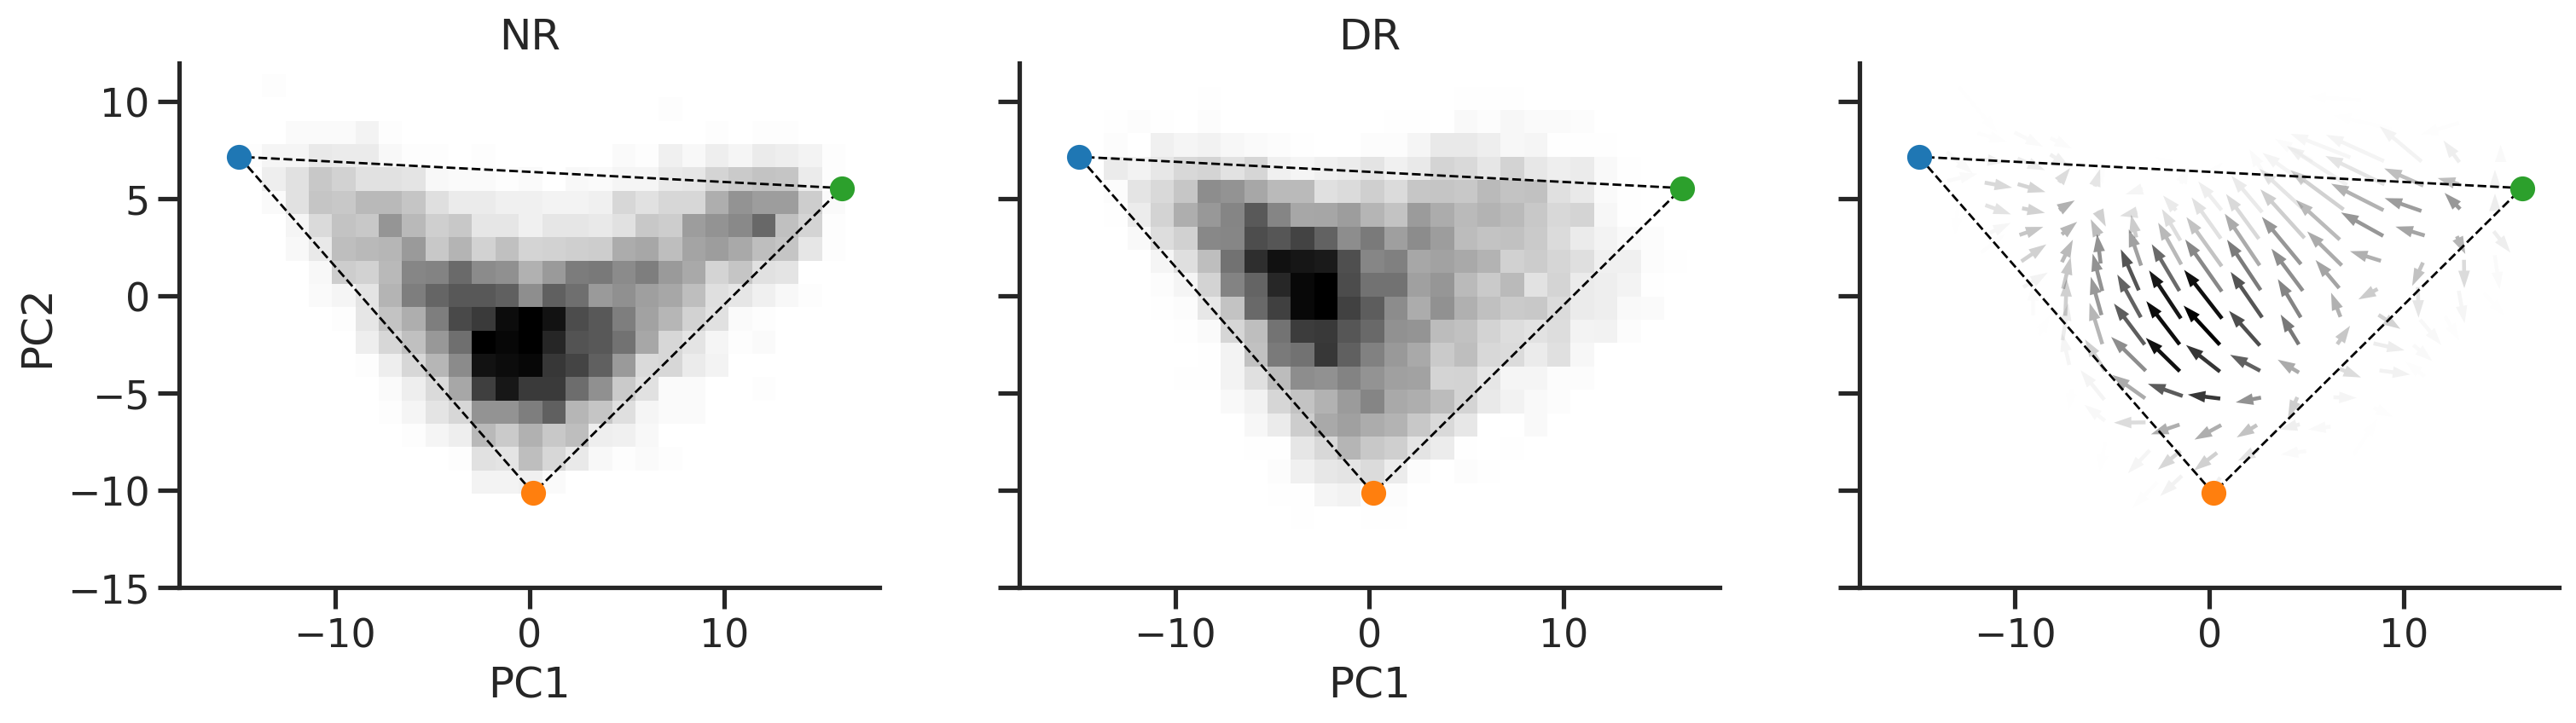

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(6*3,5*1), sharex=True, sharey=True)
for ax, lbl in zip(axs.flat, labels_m):
    adatasub = adata_dict[lbl]
    n = len(adatasub)
    g = sns.histplot(ax=ax, data=adatasub.obs, x='PC1', y='PC2', 
                 stat='percent', binwidth=1.2, vmin=0, vmax=1.5,
                 cmap='gray_r', cbar=False, cbar_kws=dict(shrink=0.5))
    
    add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
    ax.grid(False)
    sns.despine(ax=ax)
    
    ax.set_title(lbl) # +f'\n{n} cells')
    # ax.set_title(lbl+f'\n{n} cells')
    ax.set_aspect('equal')
    ax.set_xlim([-18,18])
    ax.set_ylim([-15,12])
    
ax = axs[2]
OT_plot_ax(ax, n_arrows, mean_arrows)
add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)
ax.grid(False)
ax.set_aspect('equal')
sns.despine(ax=ax)
    
output = os.path.join(outfigdir, 'aa6.pdf')
powerplots.savefig_autodate(fig, output)
plt.show()

# DR-NR use the same as MERFISH

In [61]:
from matplotlib.colors import LinearSegmentedColormap

colors_a = [(0.0, 'black'), (1.0, 'C0')]      
colors_b = [(0.0, 'black'), (1.0, 'C1')]      
colors_c = [(0.0, 'black'), (1.0, 'C2')]      

colors_nrdr = [(0.0, 'C1'), (0.5, 'white'), (1.0, 'black')]
colors_nr = [(0.0, 'white'), (1.0, 'C1'),]
colors_dr = [(0.0, 'white'), (1.0, 'black'),]

# Create a custom colormap using LinearSegmentedColormap
cmap_a = LinearSegmentedColormap.from_list('cmap_a', colors_a)
cmap_b = LinearSegmentedColormap.from_list('cmap_b', colors_b)
cmap_c = LinearSegmentedColormap.from_list('cmap_c', colors_c)
cmap_nrdr = LinearSegmentedColormap.from_list('cmap_nrdr', colors_nrdr)
cmap_nr = LinearSegmentedColormap.from_list('cmap_nr', colors_nr)
cmap_dr = LinearSegmentedColormap.from_list('cmap_dr', colors_dr)

In [62]:
labels_m


['NR', 'DR']

[-18.  -16.8 -15.6 -14.4 -13.2 -12.  -10.8  -9.6  -8.4  -7.2  -6.   -4.8
  -3.6  -2.4  -1.2   0.    1.2   2.4   3.6   4.8   6.    7.2   8.4   9.6
  10.8  12.   13.2  14.4  15.6  16.8  18. ]
[-15.         -13.77272727 -12.54545455 -11.31818182 -10.09090909
  -8.86363636  -7.63636364  -6.40909091  -5.18181818  -3.95454545
  -2.72727273  -1.5         -0.27272727   0.95454545   2.18181818
   3.40909091   4.63636364   5.86363636   7.09090909   8.31818182
   9.54545455  10.77272727  12.        ]
(30, 22)
(30, 22)


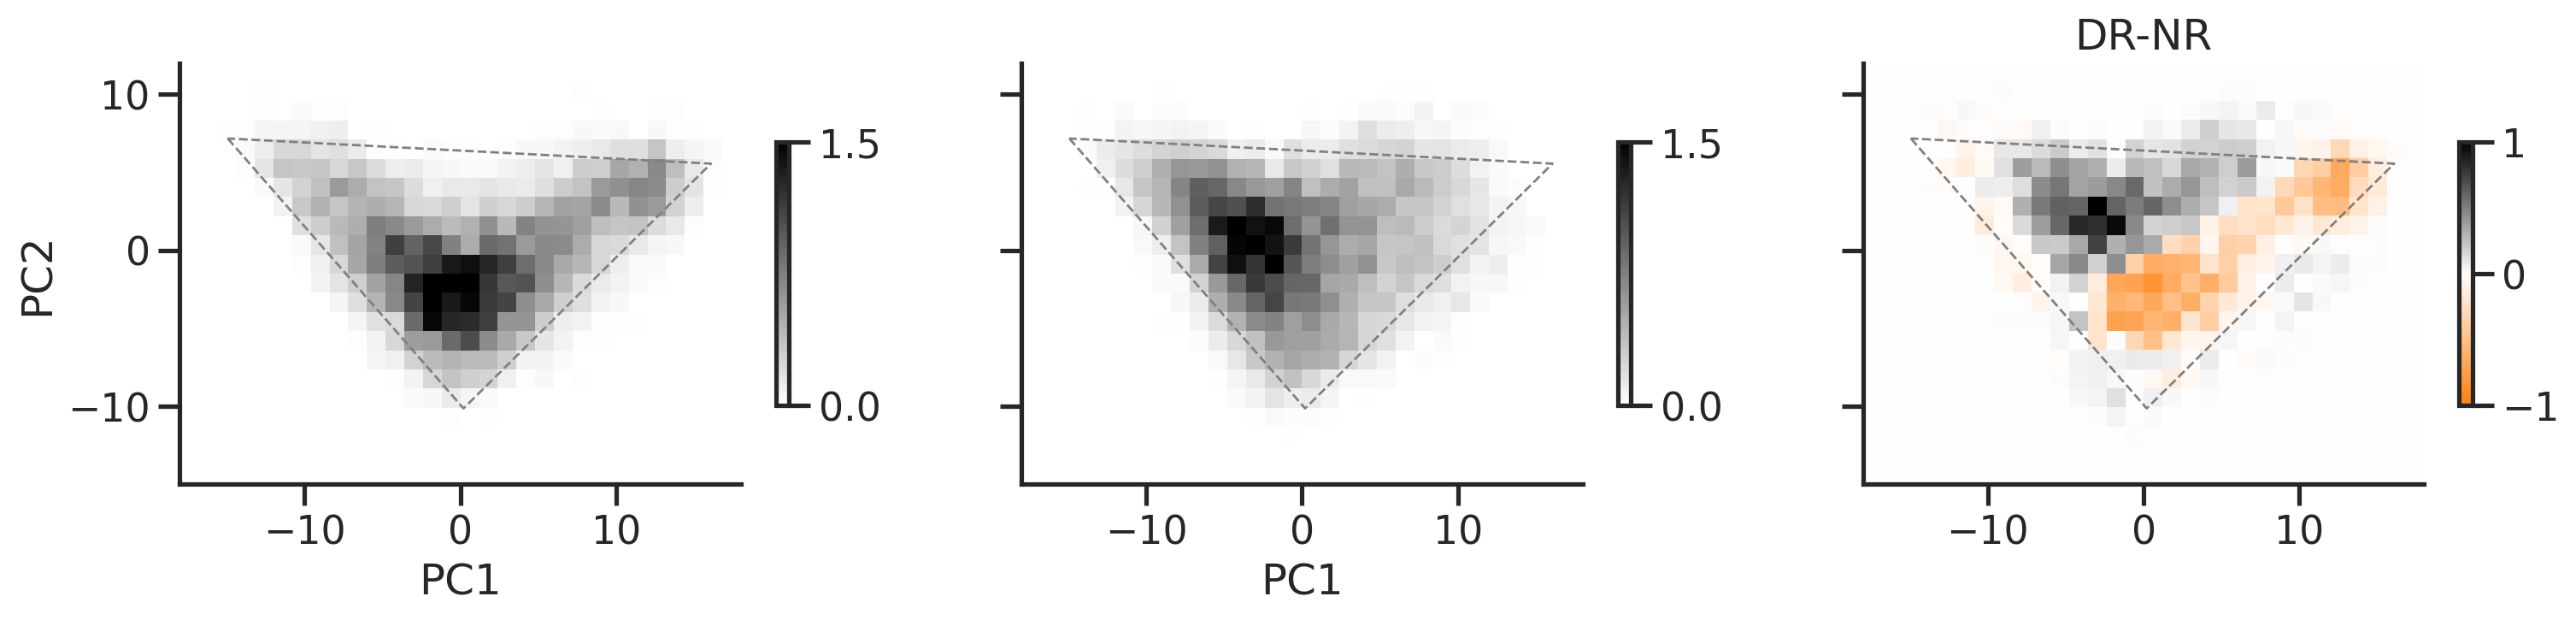

In [63]:
xmin, xmax = -18, 18
ymin, ymax = -15, 12

bins_x = np.linspace(xmin, xmax, int((xmax-xmin)/1.2+1))
bins_y = np.linspace(ymin, ymax, int((ymax-ymin)/1.2+1))
print(bins_x)
print(bins_y)

hists = []
fig, axs = plt.subplots(1,3,figsize=(3*6,1*5), sharex=True, sharey=True)
for ax, lbl in zip(axs.flat, labels_m):
    adatasub = adata_dict[lbl]
    x =  adatasub.obs['PC1']
    y =  adatasub.obs['PC2']
    sns.histplot(x=x, y=y, ax=ax, bins=(bins_x, bins_y), 
                 cmap='gray_r', 
                 stat='percent', vmin=0, vmax=1.5, 
                 cbar=True, cbar_kws=dict(shrink=0.4, ticks=[0,1.5]))
    
    hist, _, _= np.histogram2d(x, y, bins=(bins_x, bins_y))
    hist = hist/len(x)*100
    hists.append(hist)
    print(hist.shape)
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
    # add the triangle
    add_triangle(XC, ax, zorder=2)
    
ax = axs[2] 
ax.set_title('DR-NR')
g = ax.imshow(
    pd.DataFrame(hists[1]-hists[0],  
                index  =bins_x[1:]-1.2/2, 
                columns=bins_y[1:]-1.2/2).T, 
            origin='lower',
            extent=(xmin, xmax, ymin, ymax),
            # cmap='coolwarm', 
            cmap=cmap_nrdr, 
            vmax=1.0, vmin=-1.0)
# ax.invert_yaxis()
ax.set_aspect('equal')
ax.grid(False)
fig.colorbar(g, shrink=0.4, ticks=[-1,0,1])
sns.despine(ax=ax)

# add the triangle
add_triangle(XC, ax, zorder=2)
# add_triangle(XC, ax, vertices=True, linewidth=1, linecolor='k', zorder=2)

plt.show()

In [64]:
len(adata_dict['NR']), len(adata_dict['DR'])

(6741, 9869)

# Quantify JS distance v2 (NR DR only)

In [65]:
from scipy.spatial.distance import jensenshannon
from scipy.cluster import hierarchy as sch

In [66]:
# labels
labels3 = labels
dfs3 = [adata_dict[lbl].obs for lbl in labels3]
print(labels3)

['P28NR', 'P38NR', 'P28DR', 'P38DR']


In [67]:
bins = np.arange(-15, 15+2, 1)
hists3 = []
for df in dfs3:
    a, _, _ = np.histogram2d(df['PC1'], df['PC2'], bins=bins)
    a = a/np.sum(a)*100
    hists3.append(a)

In [68]:
res_js3 = np.zeros((4,4))
js_min = 1
for i in np.arange(4):
    for j in np.arange(4):
        if j > i:
            p = np.ravel(hists3[i])
            q = np.ravel(hists3[j])
            p = p/np.sum(p)
            q = q/np.sum(q)
            js = jensenshannon(p, q) 
            
            res_js3[i,j] = js
            res_js3[j,i] = js
            js_min = min(js, js_min)

In [69]:
# order = [2,0,3,1,4]
order3, Z3 = basicu.order_by_hc(res_js3, return_Z=True) # [::-1]
# np.array(labels)[order]

/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py:437: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(X, method=method, metric=metric)


In [70]:
js_min

0.22444691159676028

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/js_heatmap_nrdr_only_2024-09-10.pdf


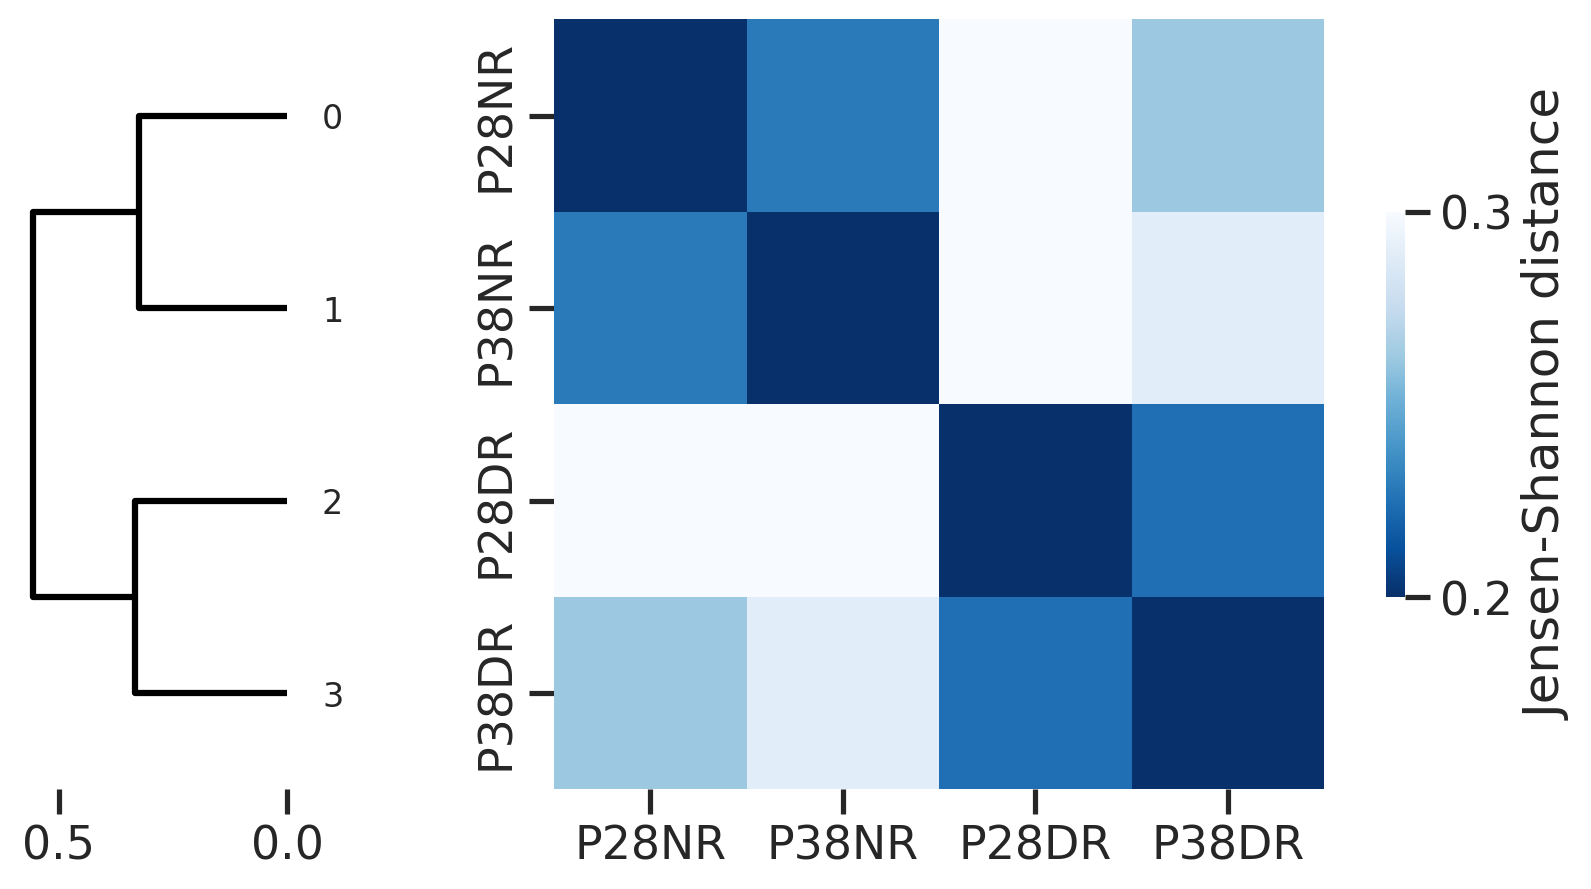

In [71]:
fig, axs = plt.subplot_mosaic("ABBBB", figsize=(10,5))

ax = axs['A']
d = sch.dendrogram(Z3, ax=ax, orientation='left', above_threshold_color='k', color_threshold=0)
sns.despine(ax=ax, left=True, bottom=True)
ax.invert_yaxis()
ax.grid(False)

ax = axs['B']
sns.heatmap(pd.DataFrame(res_js3).reindex(order3)[order3], cmap='Blues_r', 
            # vmin=js_min, vmax=0.4,
            # vmin=js_min,
            vmin=0.2,
            vmax=0.3,
            cbar_kws=dict(shrink=0.5, ticks=[0.2, 0.3], label='Jensen-Shannon distance'),
            xticklabels=np.array(labels3)[order3],
            yticklabels=np.array(labels3)[order3],
            ax=ax,
           )
ax.set_aspect('equal')
output = os.path.join(outfigdir, "js_heatmap_nrdr_only.pdf")
powerplots.savefig_autodate(fig, output)

# stability analysis

In [72]:
def shuff_genes(mat, seed=0):
    """
    shuffle each column independently
    
    if cell by gene as input; it will shuffle each gene independently across cells
    """
    rng = np.random.default_rng(seed=seed)
    mat_shuff = rng.permuted(mat, axis=0)
    return mat_shuff

In [73]:
def downsample_X(X, p=0.8):
    """downsample cells (assuming it is feature by cell matrix)
    """
    return X[:,np.random.rand(X.shape[1])<p]

In [74]:
def aa_inference(X):
    """
    """
    XC, _, _, _, _ = PCHA(X, noc=3, delta=0)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])] # assign an order according to x-axis 
    return XC

In [75]:
adata_nr_p28 = adata_nr[adata_nr.obs['cond']=='P28NR']
mat = stats.zscore(np.array(adata_nr_p28.layers['lognorm'].todense()), axis=0)
adata_nr_p28

View of AnnData object with n_obs × n_vars = 4044 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'biosample', 'easitype', 'PC1', 'PC2'
    obsm: 'pcs', 'size_freq_abc'
    layers: 'norm', 'lognorm'

In [76]:
pcs_nr_p28 = PCA(n_components=2).fit_transform(mat) 
X = pcs_nr_p28.T

# orig
XC = aa_inference(X) 

np.random.seed(0)
# stability - downsamp cells
nrepeats = 20
res_XC_sub = []
for i in range(nrepeats):
    X_sub = downsample_X(X, p=0.8)
    XC_sub = aa_inference(X_sub) 
    res_XC_sub.append(XC_sub)
    

In [77]:

np.random.seed(0)
# stability - downsamp genes
nrepeats = 20
res_XC_sub2 = []
for i in range(nrepeats):
    mat_sub = downsample_X(mat, p=0.8) # downsamp genes
    pcs = PCA(n_components=2).fit_transform(mat_sub)
    X_sub = pcs.T
    
    xcorr = stats.pearsonr(X[0], X_sub[0])[0]
    ycorr = stats.pearsonr(X[1], X_sub[1])[0]
    if xcorr > 0:
        xsign = 1
    else:
        xsign = -1
    if ycorr > 0:
        ysign = 1
    else:
        ysign = -1
        
    X_sub = np.diag([xsign, ysign]).dot(X_sub)
    
    XC_sub = aa_inference(X_sub) 
    res_XC_sub2.append(XC_sub)

In [78]:
mat.shape, mat_sub.shape

((4044, 286), (4044, 227))

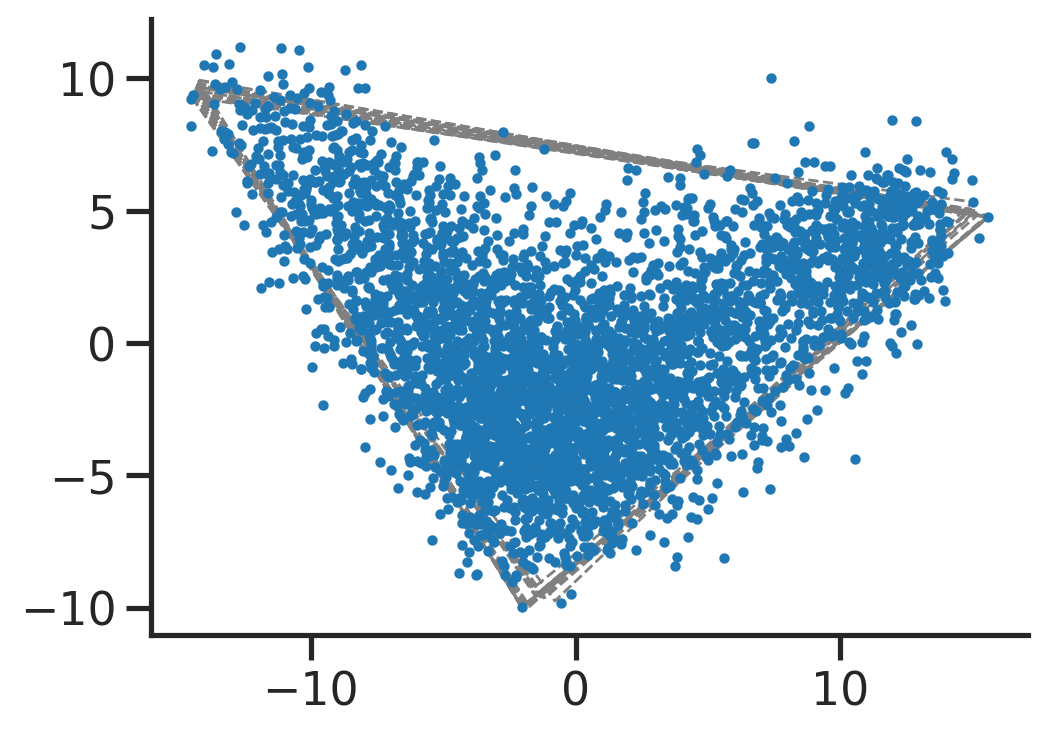

In [79]:
fig, ax = plt.subplots(1,1,figsize=(6*1,4))
ax.scatter(X[0], X[1], s=5) # , c=rgbs) # , cmap='coolwarm', vmin_p=5, vmax_p=95)

# add_triangle(XC, ax, vertices=True, linecolor='k', edgecolors='k', linewidths=1, marker='o', zorder=2)
for i in range(nrepeats):
    XC_i = res_XC_sub[i]
    add_triangle(XC_i, ax, zorder=0, vertices=False, linecolor='gray',)
    
ax.set_aspect('equal')
sns.despine(ax=ax)
ax.grid(False)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/2_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/2.pdf


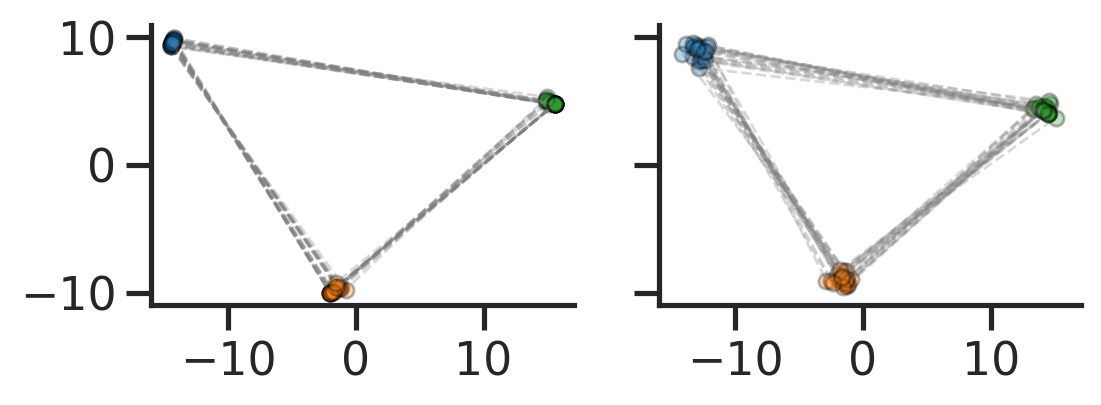

In [80]:
fig, axs = plt.subplots(1,2,figsize=(3*2,2), sharex=True, sharey=True)
ax = axs[0]
for i in range(nrepeats):
    XC_i = res_XC_sub[i]
    add_triangle(XC_i, ax, zorder=0, vertices=True, linecolor='gray', edgecolors='k', linewidths=1, marker='o', s=30, alpha=0.3)
    
ax.set_aspect('equal')
sns.despine(ax=ax)
ax.grid(False)

ax = axs[1]
for i in range(nrepeats):
    XC_i = res_XC_sub2[i]
    add_triangle(XC_i, ax, zorder=0, vertices=True, linecolor='gray', edgecolors='k', linewidths=1, marker='o', s=30, alpha=0.3)
ax.set_aspect('equal')
sns.despine(ax=ax)
ax.grid(False)

fig_manager.savefig(fig)
plt.show()

In [81]:
from sklearn.metrics import pairwise_distances

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/9_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-4/9.pdf


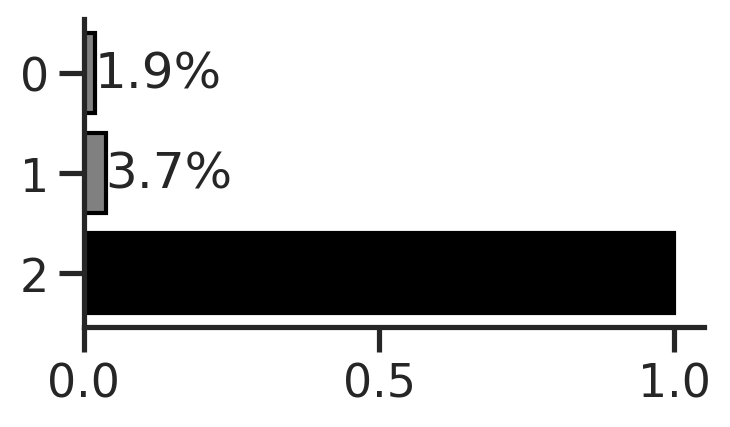

In [89]:
XC_avg = np.mean(res_XC_sub, axis=0).T
XC_std = np.std(res_XC_sub, axis=0).T
XC_std2 = np.std(res_XC_sub2, axis=0).T
# ds = pairwise_distances(XC_avg)[np.triu_indices(3, k=1)]
ds = pairwise_distances(XC_avg)
signals = np.sort(ds, axis=1)[:,1]
epsilons = np.sqrt(np.sum(np.power(XC_std,2), axis=1))
epsilons2 = np.sqrt(np.sum(np.power(XC_std2,2), axis=1))

ref = np.mean(ds)

fracs = [
    np.mean(epsilons)/ref,
    np.mean(epsilons2)/ref,
    np.mean(ds)/ref,
]

fig, ax = plt.subplots(figsize=(4,2))

ax.barh(0, fracs[0], color='gray', edgecolor='k')
ax.text(fracs[0], 0, f'{fracs[0]*100:.1f}%', ha='left', va='center')

ax.barh(1, fracs[1], color='gray', edgecolor='k')
ax.text(fracs[1], 1, f'{fracs[1]*100:.1f}%', ha='left', va='center')

ax.barh(2, fracs[2], color='k', edgecolor='k')

ax.invert_yaxis()

ax.set_yticks([0,1,2])
# ax.set_xticklabels(['uncertainty within archetypes', 'dist. between archetypes'])
# ax.set_ylabel('distance in PC space')
ax.grid(False)
sns.despine(ax=ax)
fig_manager.savefig(fig)
plt.show()